In [13]:
# Imports for image recognition model analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# Configuration for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Pandas display options configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# --- CONFIGURATION ---
TOP_N = 15 # Number of top models to display
versions = ["results-wave11", "results-wave10", "results-wave05", "results-wave04", "results-wave03", "results-wave02", "results-wave01"]
base_folder = "../models/"
metrics_folder = "metrics"
csv_files = ["best_epoch.csv", "train_accuracy.csv", "train_loss.csv", "val_accuracy.csv", "val_loss.csv"]

In [14]:
# --- UTILITY FUNCTION: Metadata Extraction ---
def extract_all_params(model_name):
    name_lower = model_name.lower()
    
    # FAMILY
    family = 'Other'
    if 'resnet18' in name_lower: family = 'ResNet18'
    elif 'resnet34' in name_lower: family = 'ResNet34'
    elif 'mobilenet_v2' in name_lower: family = 'MobileNetV2'
    elif 'mobilenet_v3' in name_lower: family = 'MobileNetV3'
    elif 'efficientnet' in name_lower: family = 'EfficientNet'

    # BATCH SIZE
    batch_match = re.search(r'[_ -]b(\d+)', name_lower)
    if not batch_match: batch_match = re.search(r'b(\d+)', name_lower)
    batch_size = int(batch_match.group(1)) if batch_match else 0
    batch_str = f"b{batch_size}" if batch_size > 0 else "Unknown"

    # LEARNING RATE
    lr_match = re.search(r'lr([0-9.e-]+)', name_lower)
    lr_val = 'Unknown'
    if lr_match:
        raw_lr = lr_match.group(1).rstrip('_')
        try:
            float_lr = float(raw_lr)
            lr_val = f"{float_lr:.0e}" 
        except:
            lr_val = raw_lr

    return pd.Series([family, batch_str, lr_val], index=['Family', 'BatchSize', 'LearningRate'])

In [15]:
# --- 1. DATA LOADING (ALL VERSIONS) ---
all_results = {}

print(f"{'='*50}\n GLOBAL LOADING\n{'='*50}")

for version in versions:
    models_folder = Path(base_folder) / version
    if not models_folder.exists():
        print(f"⚠️ Folder not found: {models_folder}")
        continue
        
    model_list = [f.name for f in models_folder.iterdir() if f.is_dir()]
    
    # Loading best_epochs
    best_epochs = {}
    for model in model_list:
        p = models_folder / model / metrics_folder / "best_epoch.csv"
        if p.exists():
            best_epochs[model] = pd.read_csv(p, header=None).iloc[0, 0]
            
    # Building results_df
    model_metrics = {}
    for model in model_list:
        if model not in best_epochs: continue
        
        model_metrics[model] = {}
        best_epoch = best_epochs[model]
        model_metrics[model]['best_epoch'] = best_epoch
        
        for csv_file in csv_files:
            if csv_file == "best_epoch.csv": continue
            metric_path = models_folder / model / metrics_folder / csv_file
            if metric_path.exists():
                metric_df = pd.read_csv(metric_path, header=None)
                if best_epoch < len(metric_df):
                    metric_name = csv_file.replace('.csv', '')
                    model_metrics[model][metric_name] = metric_df.iloc[best_epoch, 0]
    
    version_df = pd.DataFrame(model_metrics).T
    
    # Enrichment with metadata immediately
    if not version_df.empty:
        meta_data = version_df.index.to_series().apply(extract_all_params)
        version_df = pd.concat([version_df, meta_data], axis=1)
        all_results[version] = version_df
        print(f"✅ {version} : {len(version_df)} models loaded.")
    else:
         print(f"❌ {version} : No data.")

 GLOBAL LOADING
✅ results-wave11 : 5 models loaded.
✅ results-wave10 : 5 models loaded.
✅ results-wave05 : 32 models loaded.
✅ results-wave04 : 32 models loaded.
✅ results-wave03 : 24 models loaded.
✅ results-wave02 : 12 models loaded.
✅ results-wave01 : 60 models loaded.


In [16]:
for version, full_df in all_results.items():
    print(f"\n{'='*100}")
    print(f" TOP 5 : {version}")
    print(f"{'='*100}\n")
    
    # Display Top 5 table
    print(full_df.sort_values(
        by=['val_accuracy', 'val_loss'], 
        ascending=[False, True]).head(5)[['val_accuracy', 'val_loss', 'Family', 'BatchSize', 'LearningRate']])


 TOP 5 : results-wave11

                              val_accuracy  val_loss       Family BatchSize  \
mobilenet_v2_b16_lr0.001_e40        98.125    0.0588  MobileNetV2       b16   
resnet18_b32_lr0.01_e50             98.125    0.0788     ResNet18       b32   
resnet18_b32_lr0.001_e50            96.250    0.0781     ResNet18       b32   
mobilenet_v2_b32_lr0.001_e20        96.250    0.0861  MobileNetV2       b32   
mobilenet_v2_b16_lr0.01_e60         90.000    0.2126  MobileNetV2       b16   

                             LearningRate  
mobilenet_v2_b16_lr0.001_e40        1e-03  
resnet18_b32_lr0.01_e50             1e-02  
resnet18_b32_lr0.001_e50            1e-03  
mobilenet_v2_b32_lr0.001_e20        1e-03  
mobilenet_v2_b16_lr0.01_e60         1e-02  

 TOP 5 : results-wave10

                              val_accuracy  val_loss       Family BatchSize  \
resnet18_b32_lr0.001_e50           94.1558    0.1927     ResNet18       b32   
resnet18_b32_lr0.01_e50            92.2078    0.287

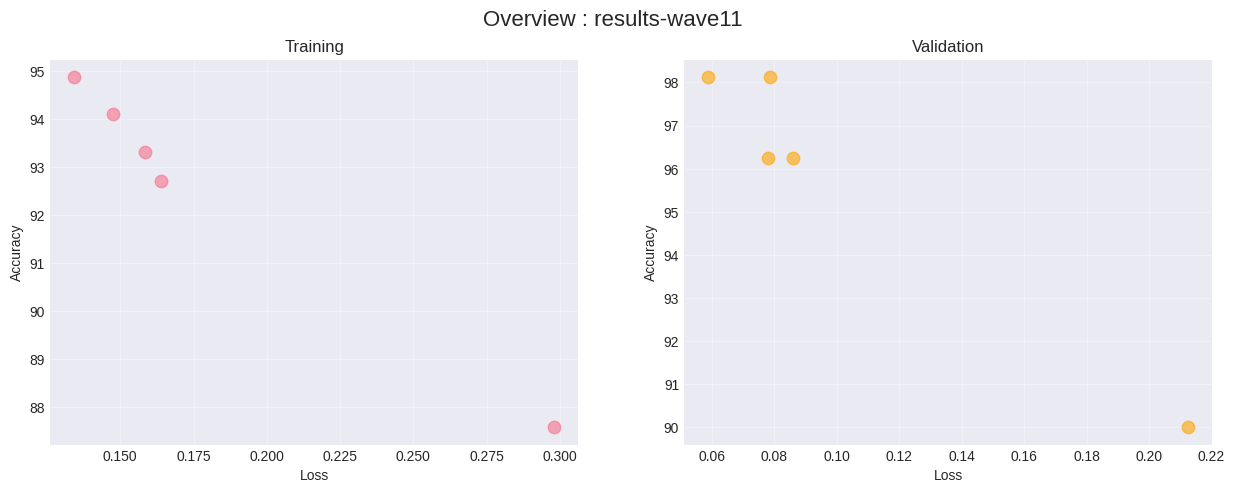

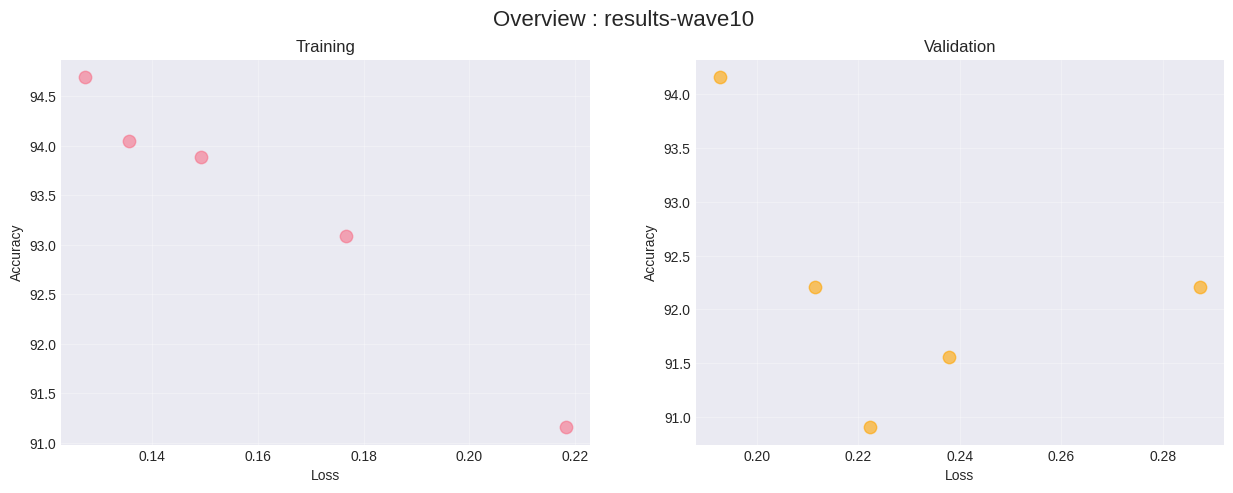

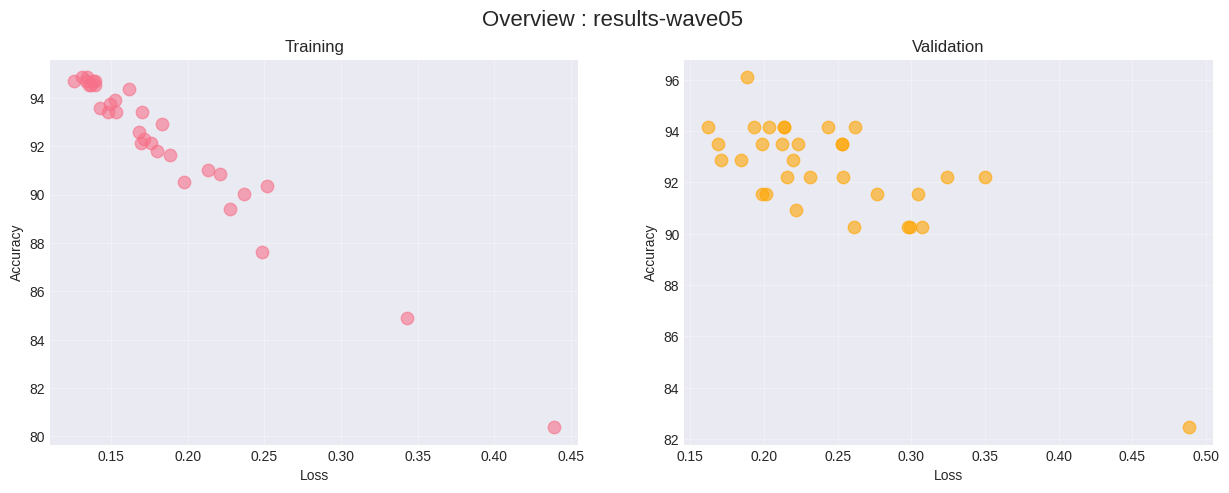

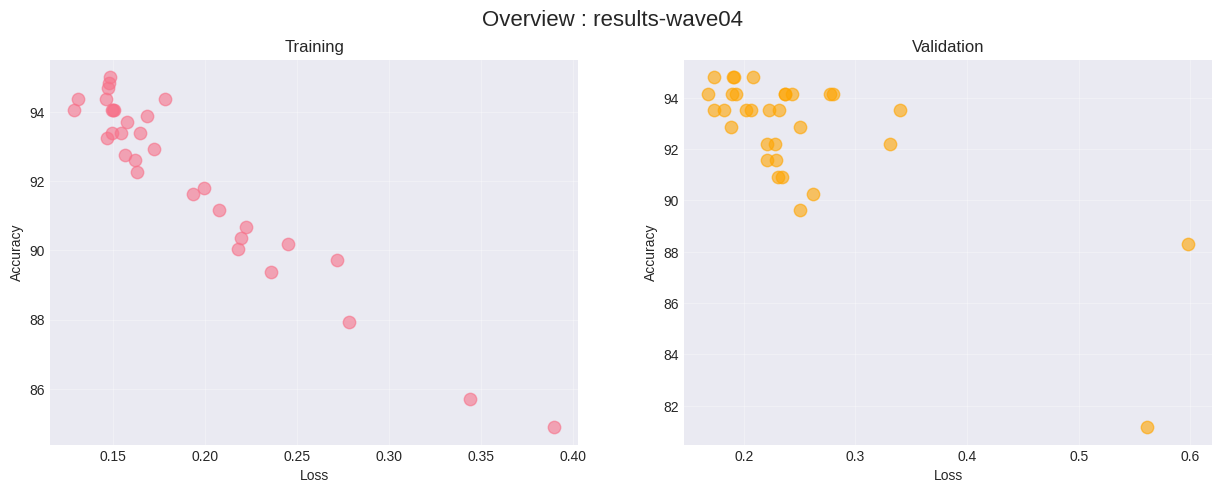

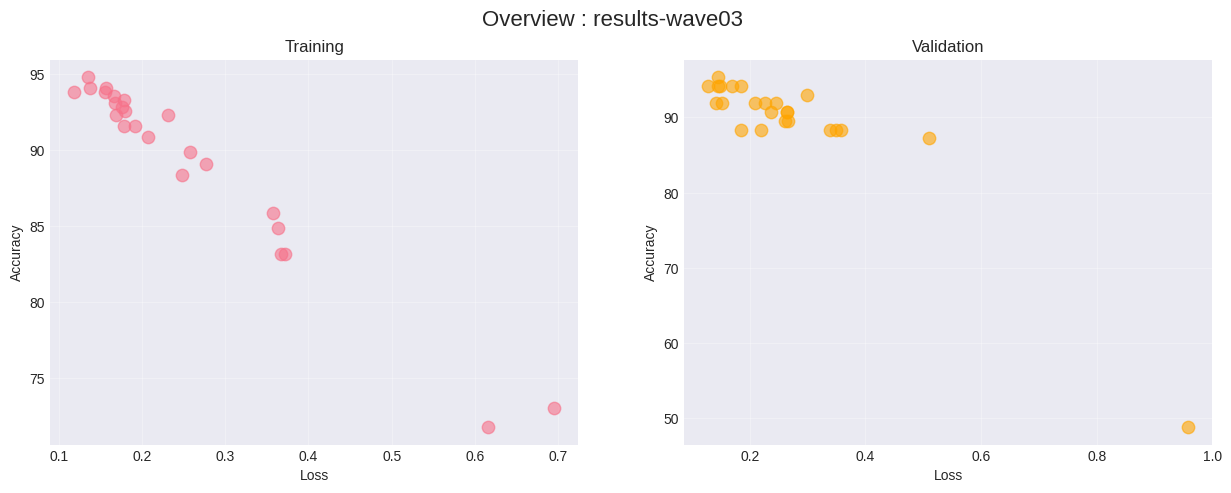

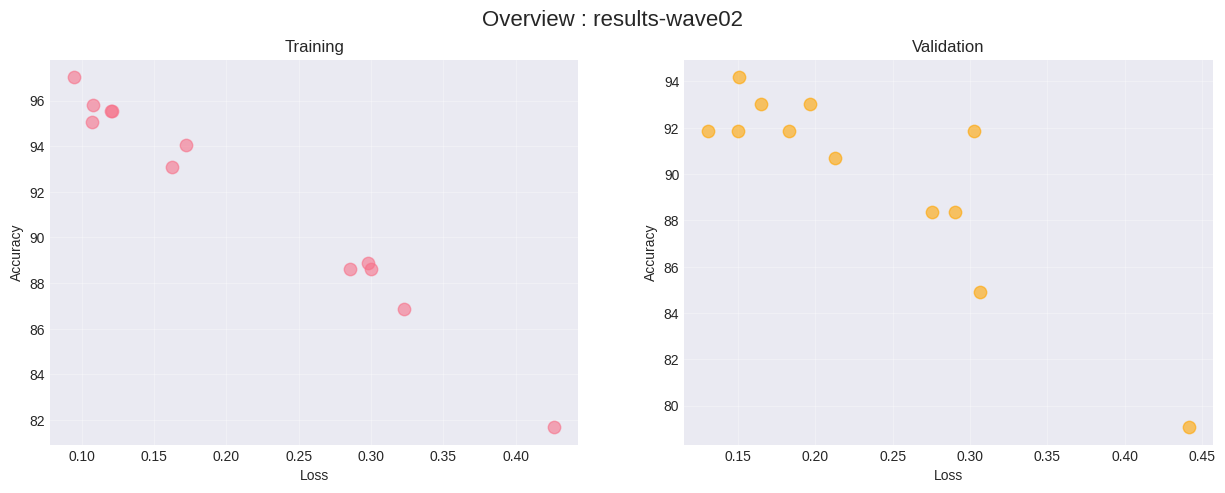

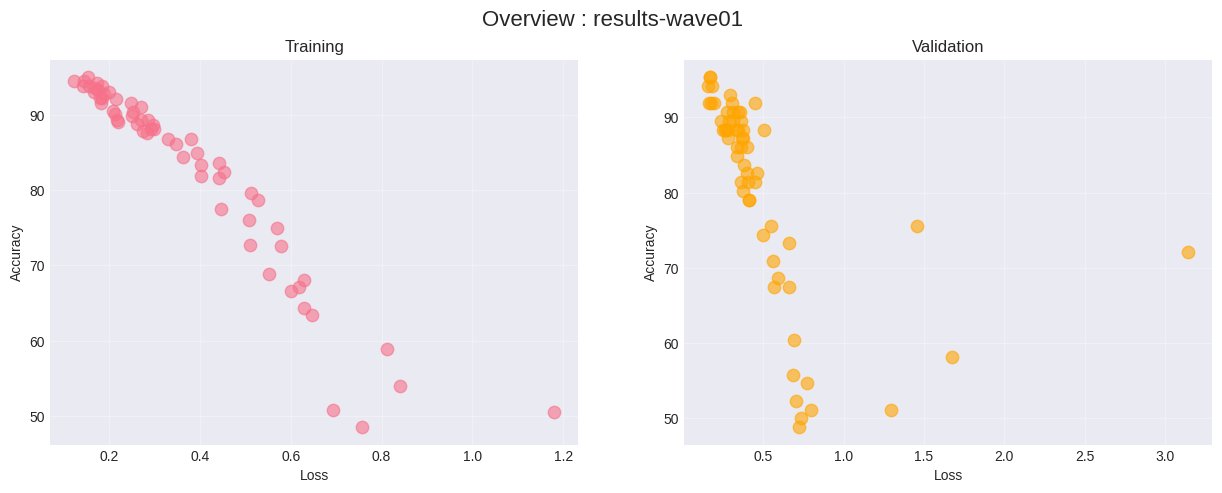

In [17]:
# --- 2. DISPLAY CHARTS ---
for version, full_df in all_results.items():

    # --- Chart 1: Overview ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Overview : {version}", fontsize=16)
    
    ax1.scatter(full_df['train_loss'], full_df['train_accuracy'], s=80, alpha=0.6)
    ax1.set_title('Training'); ax1.set_xlabel('Loss'); ax1.set_ylabel('Accuracy')
    ax1.grid(True, alpha=0.3)
    
    ax2.scatter(full_df['val_loss'], full_df['val_accuracy'], s=80, alpha=0.6, color='orange')
    ax2.set_title('Validation'); ax2.set_xlabel('Loss'); ax2.set_ylabel('Accuracy')
    ax2.grid(True, alpha=0.3)
    plt.show()

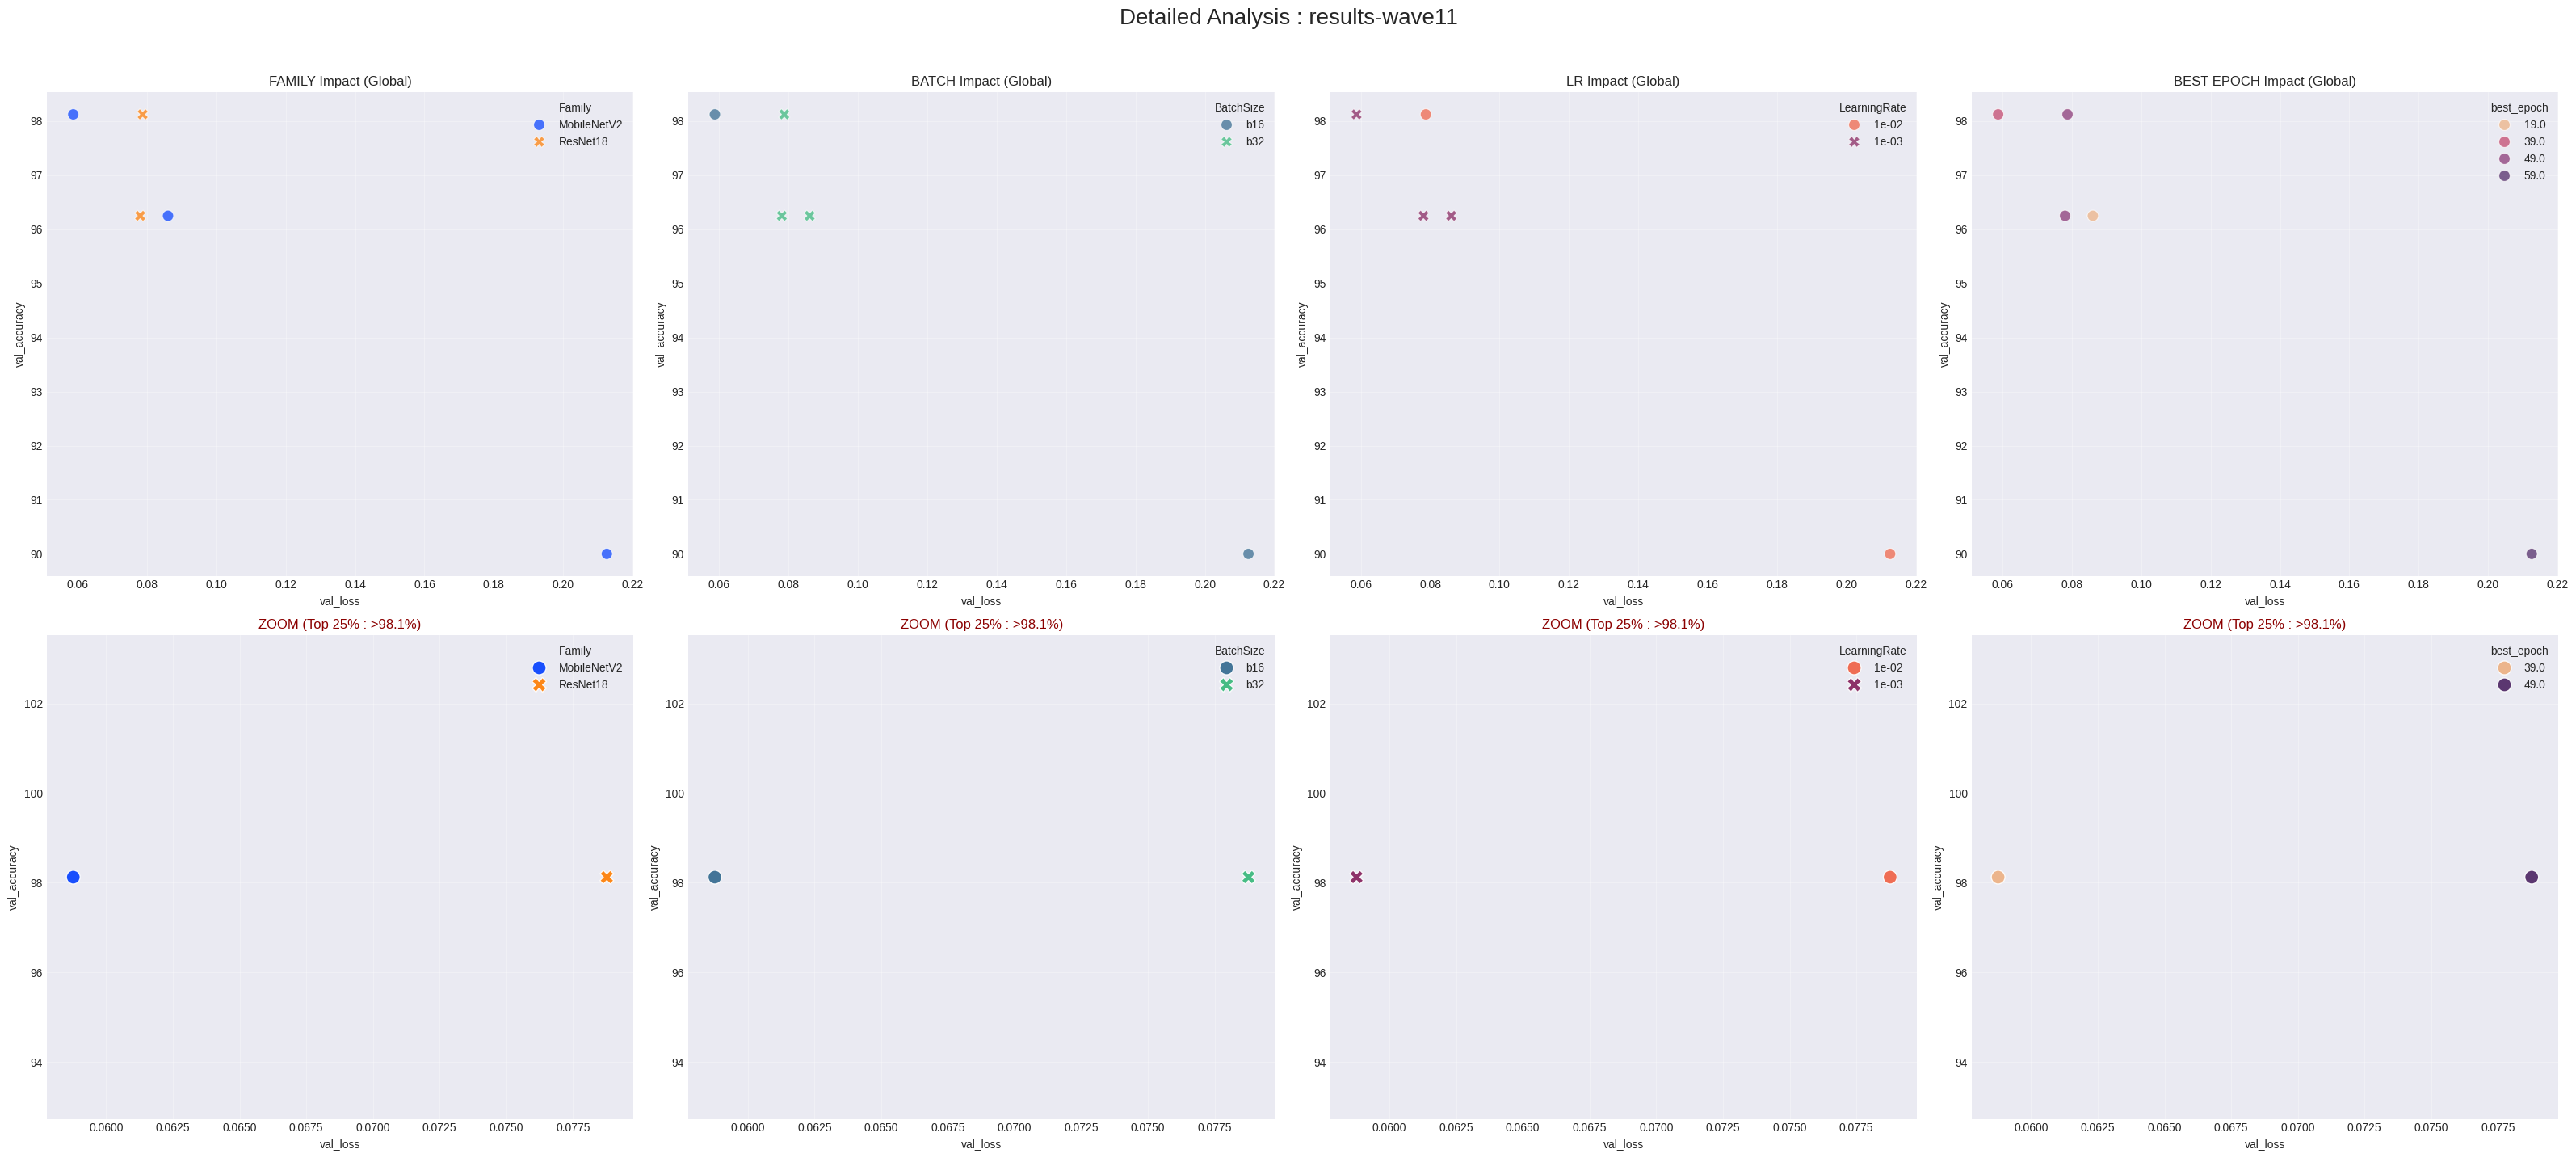

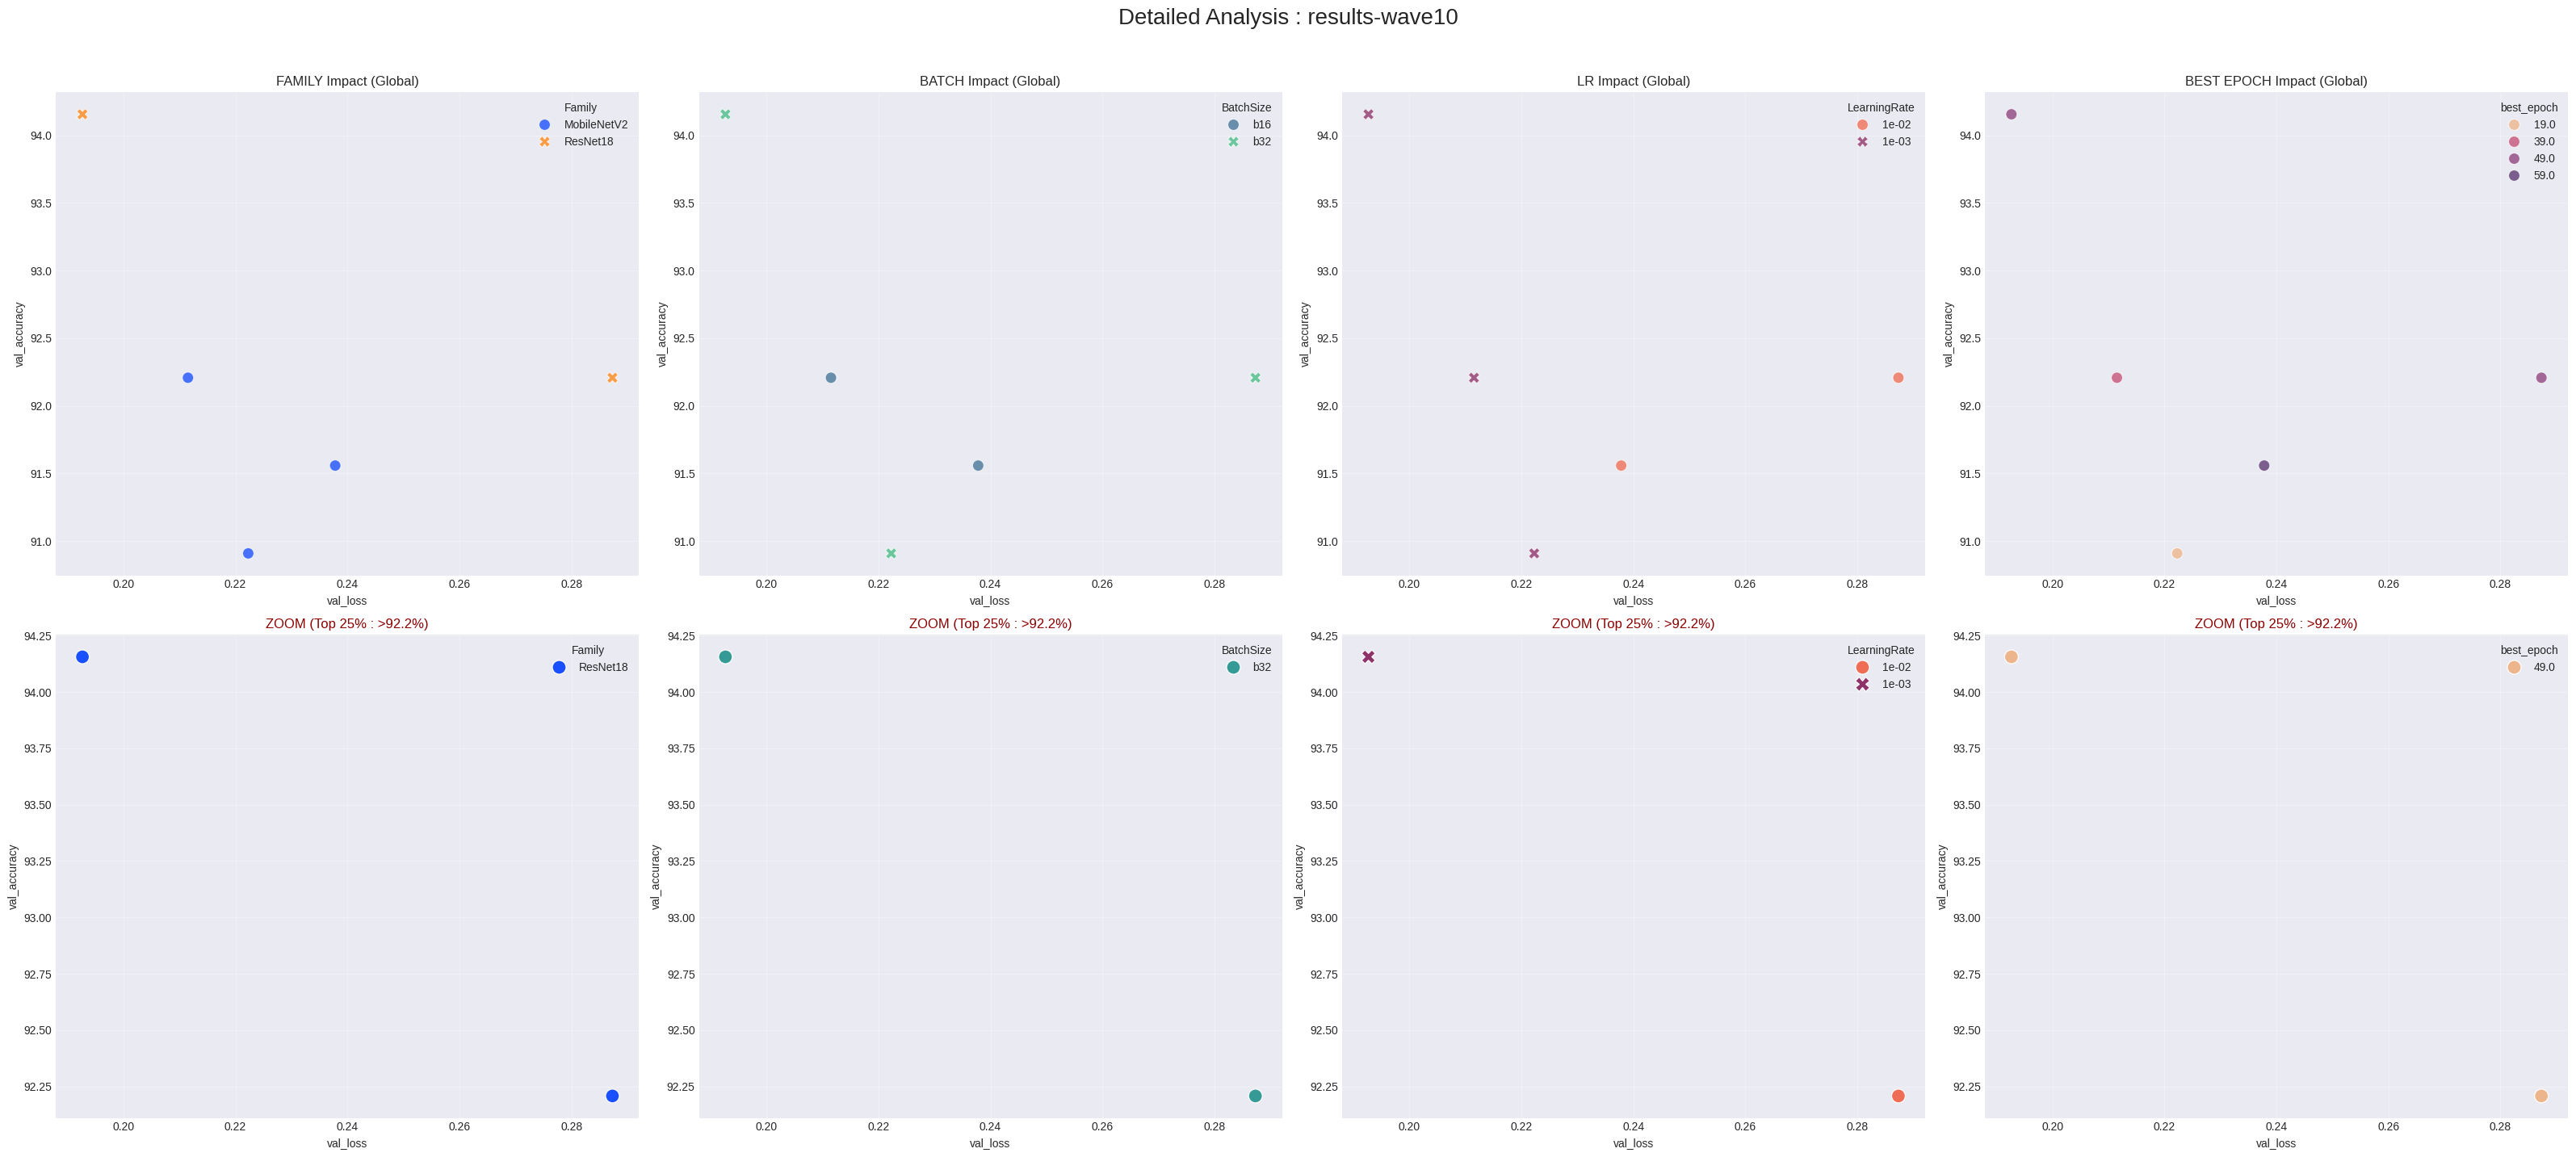

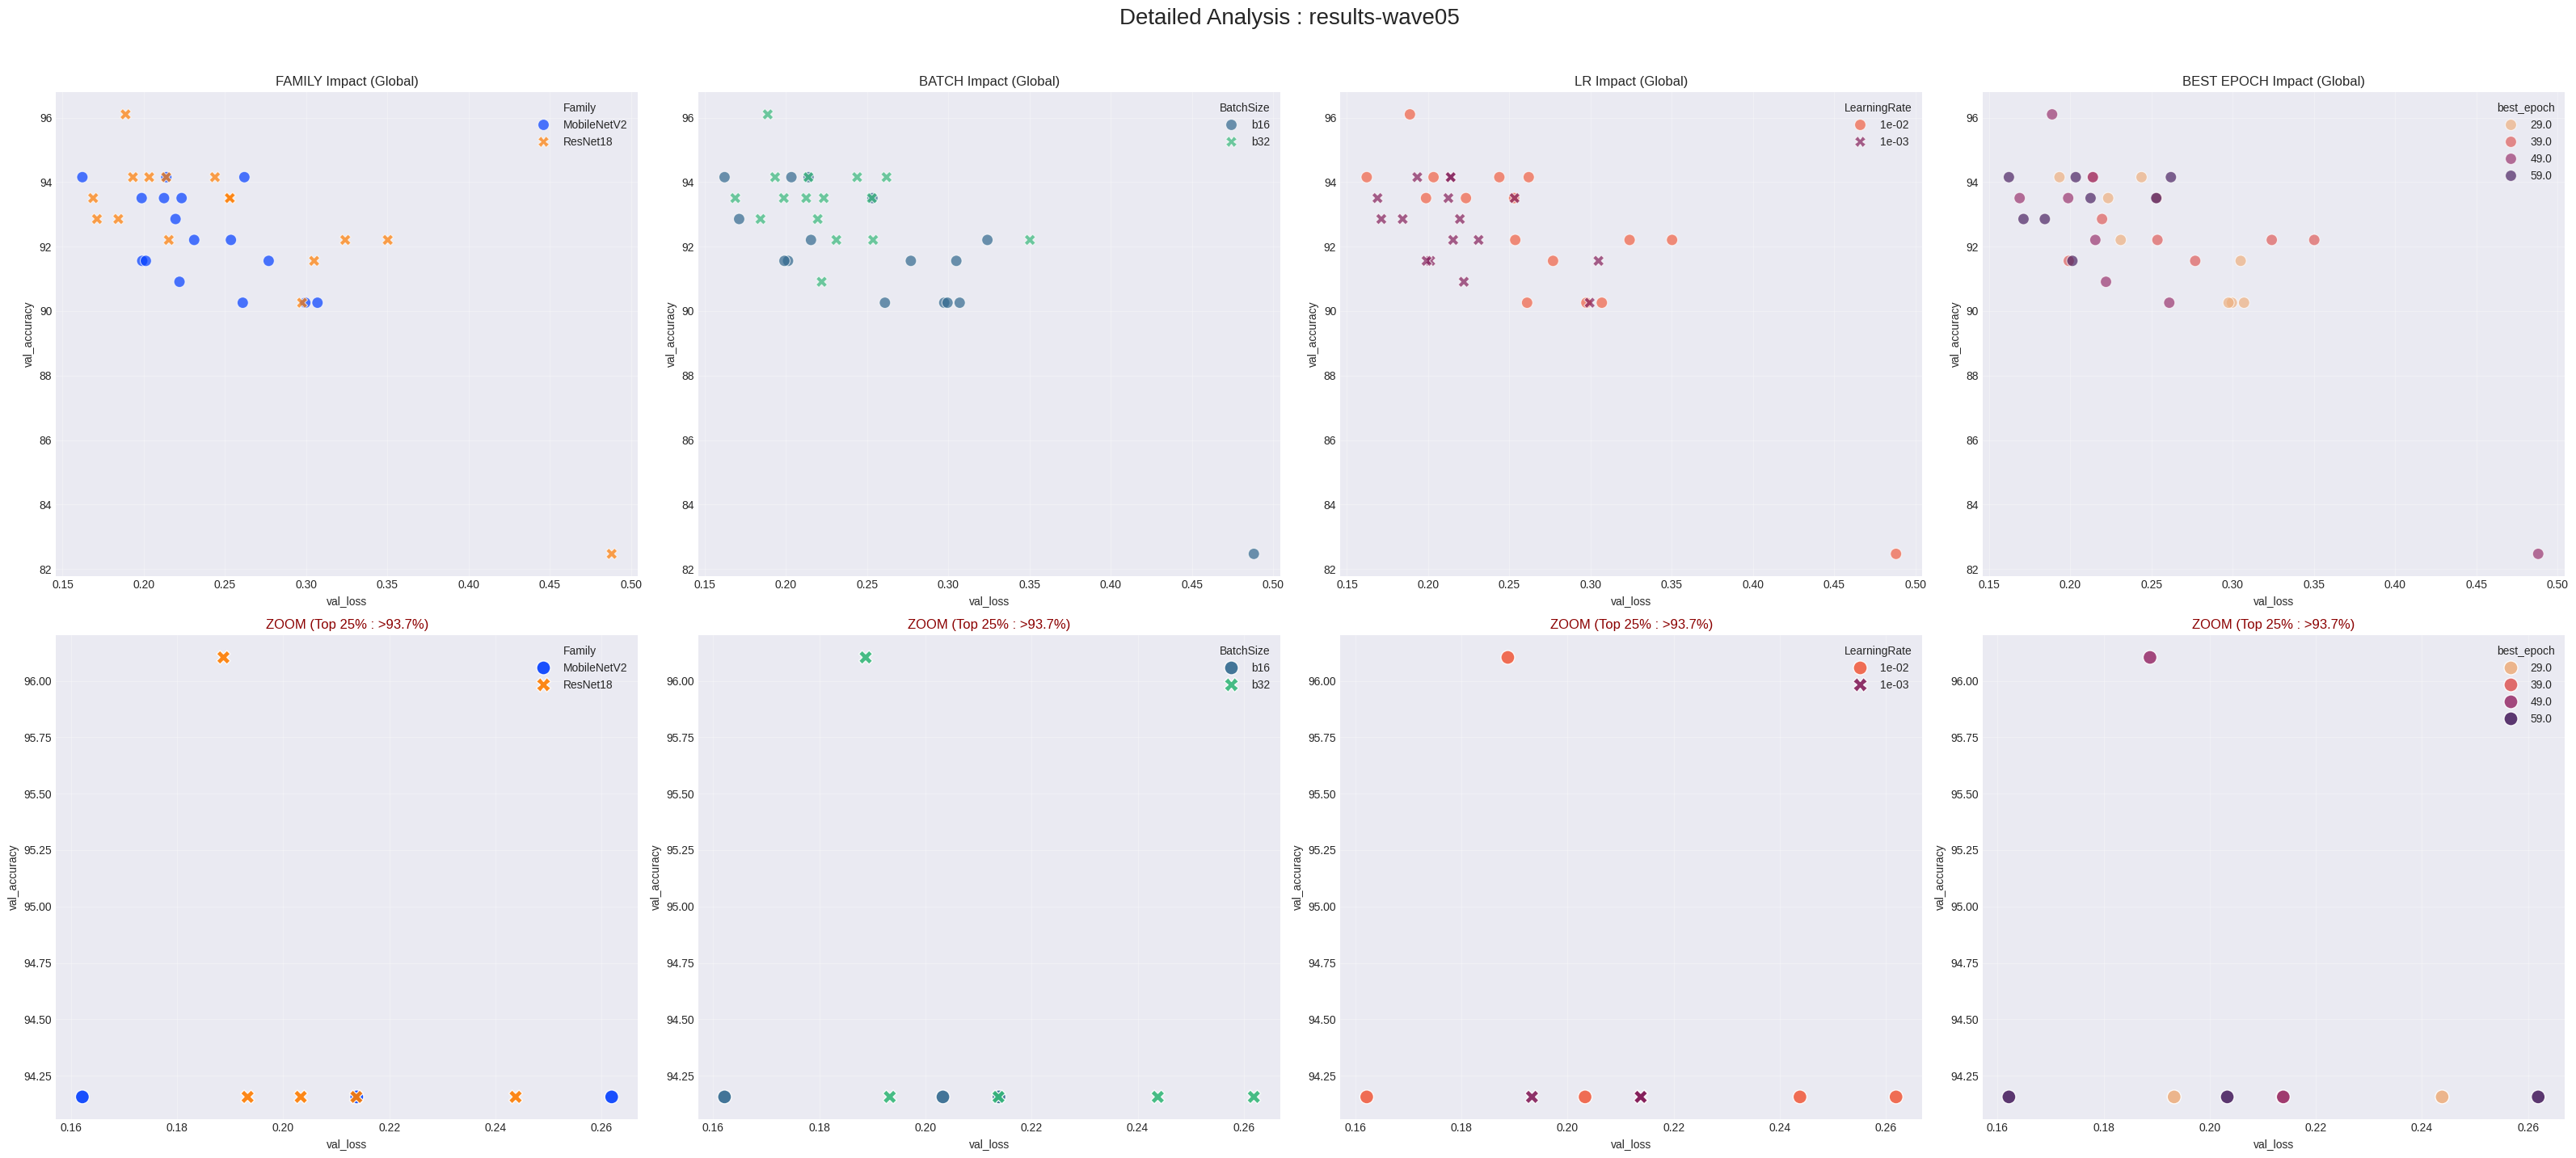

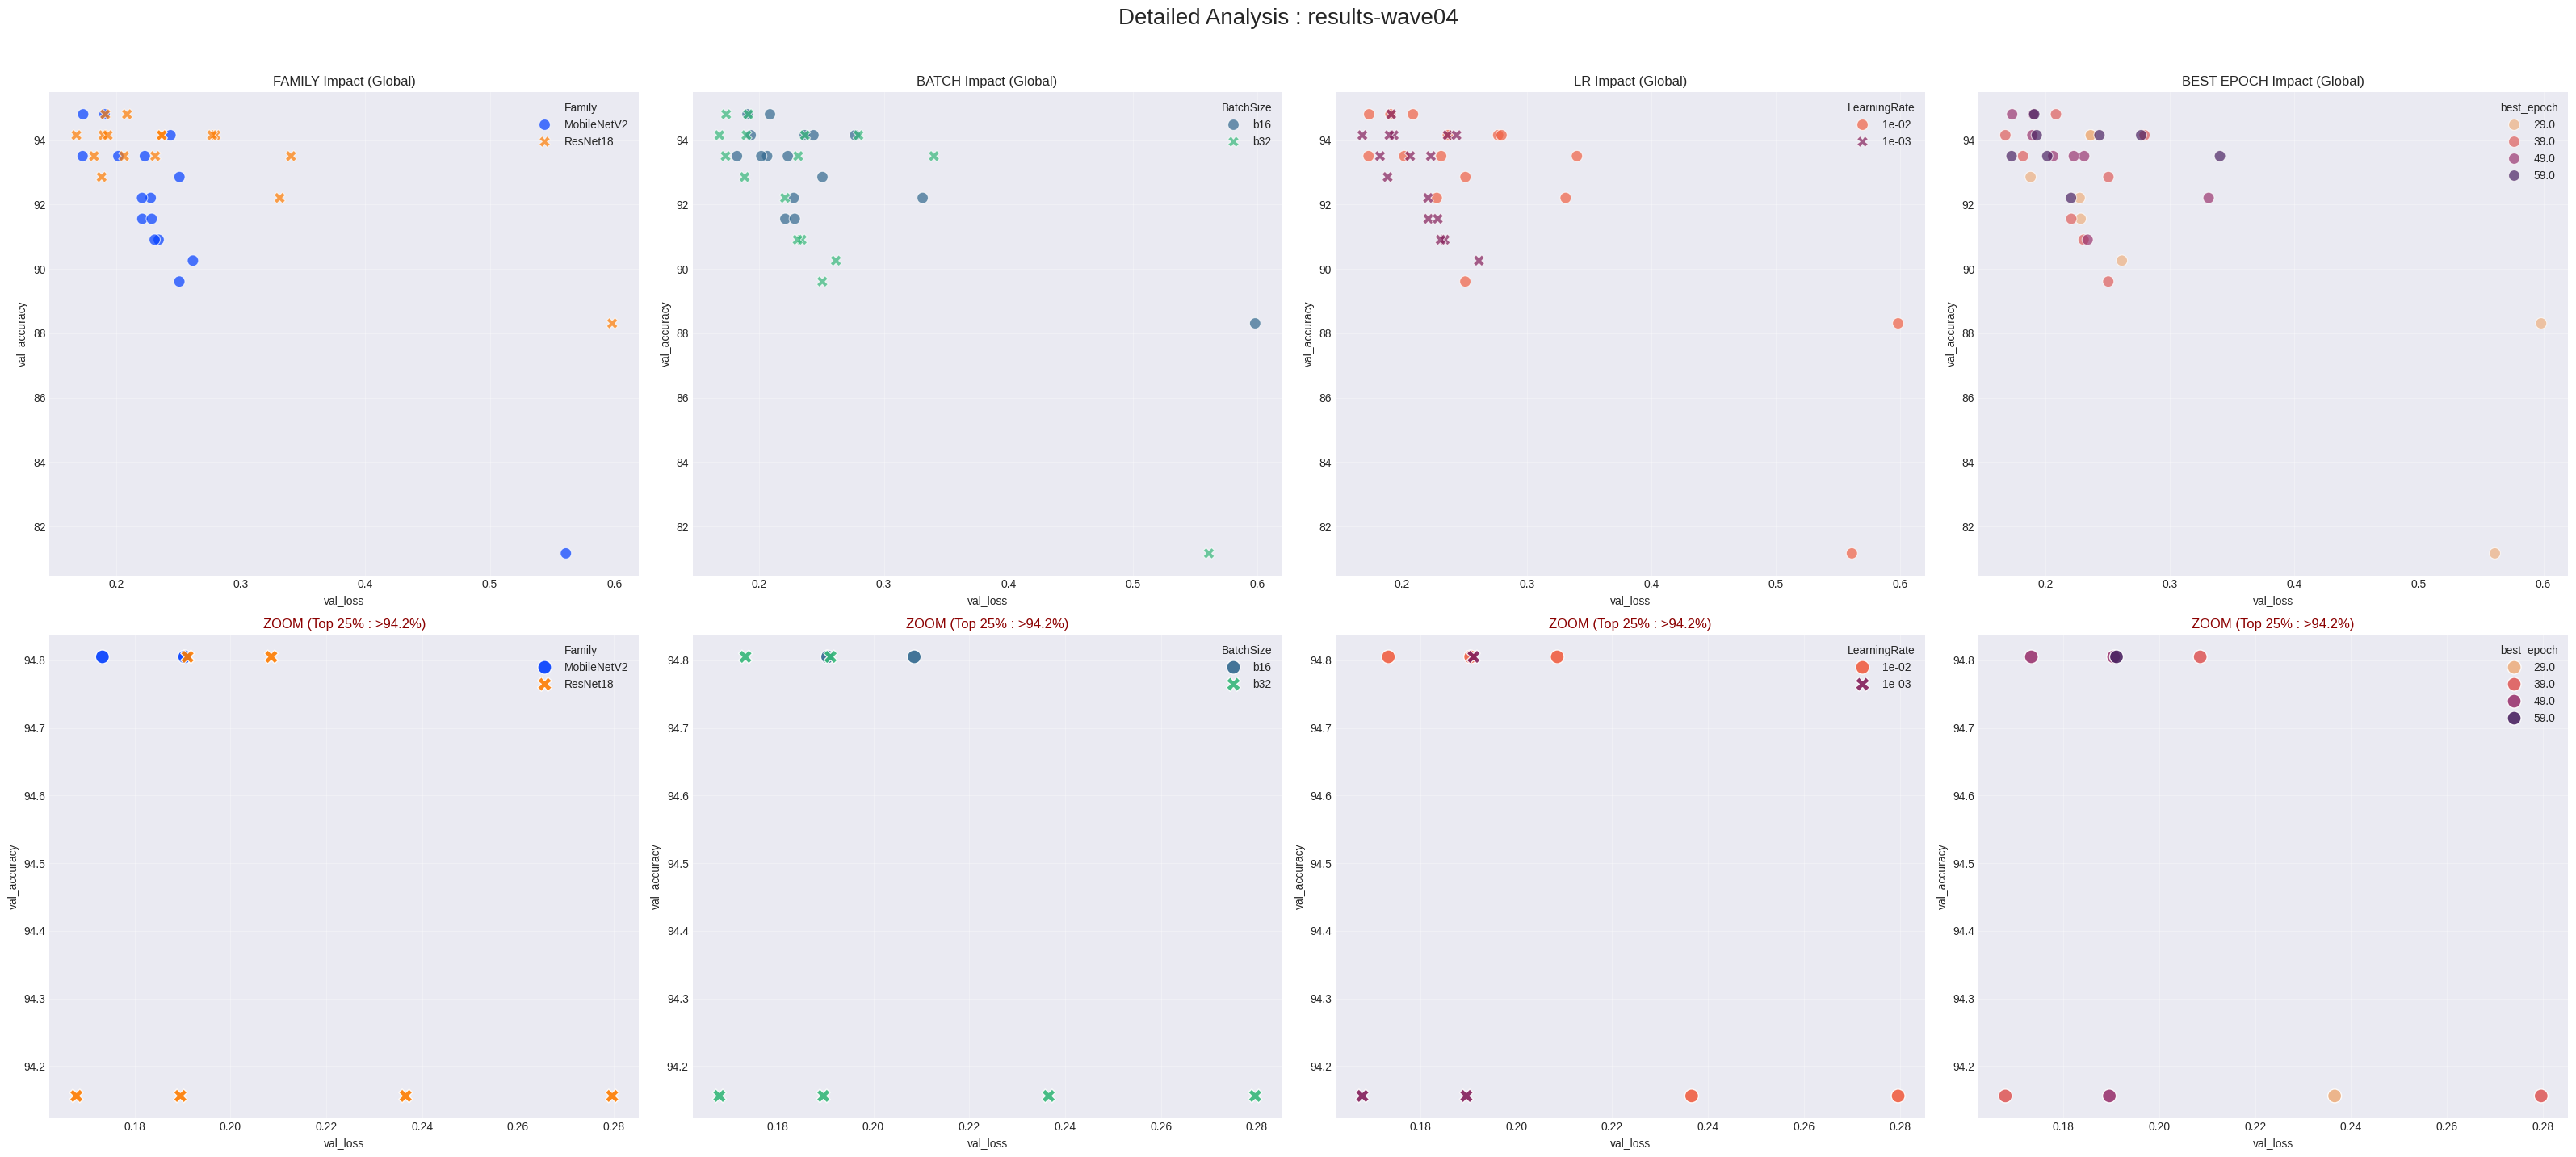

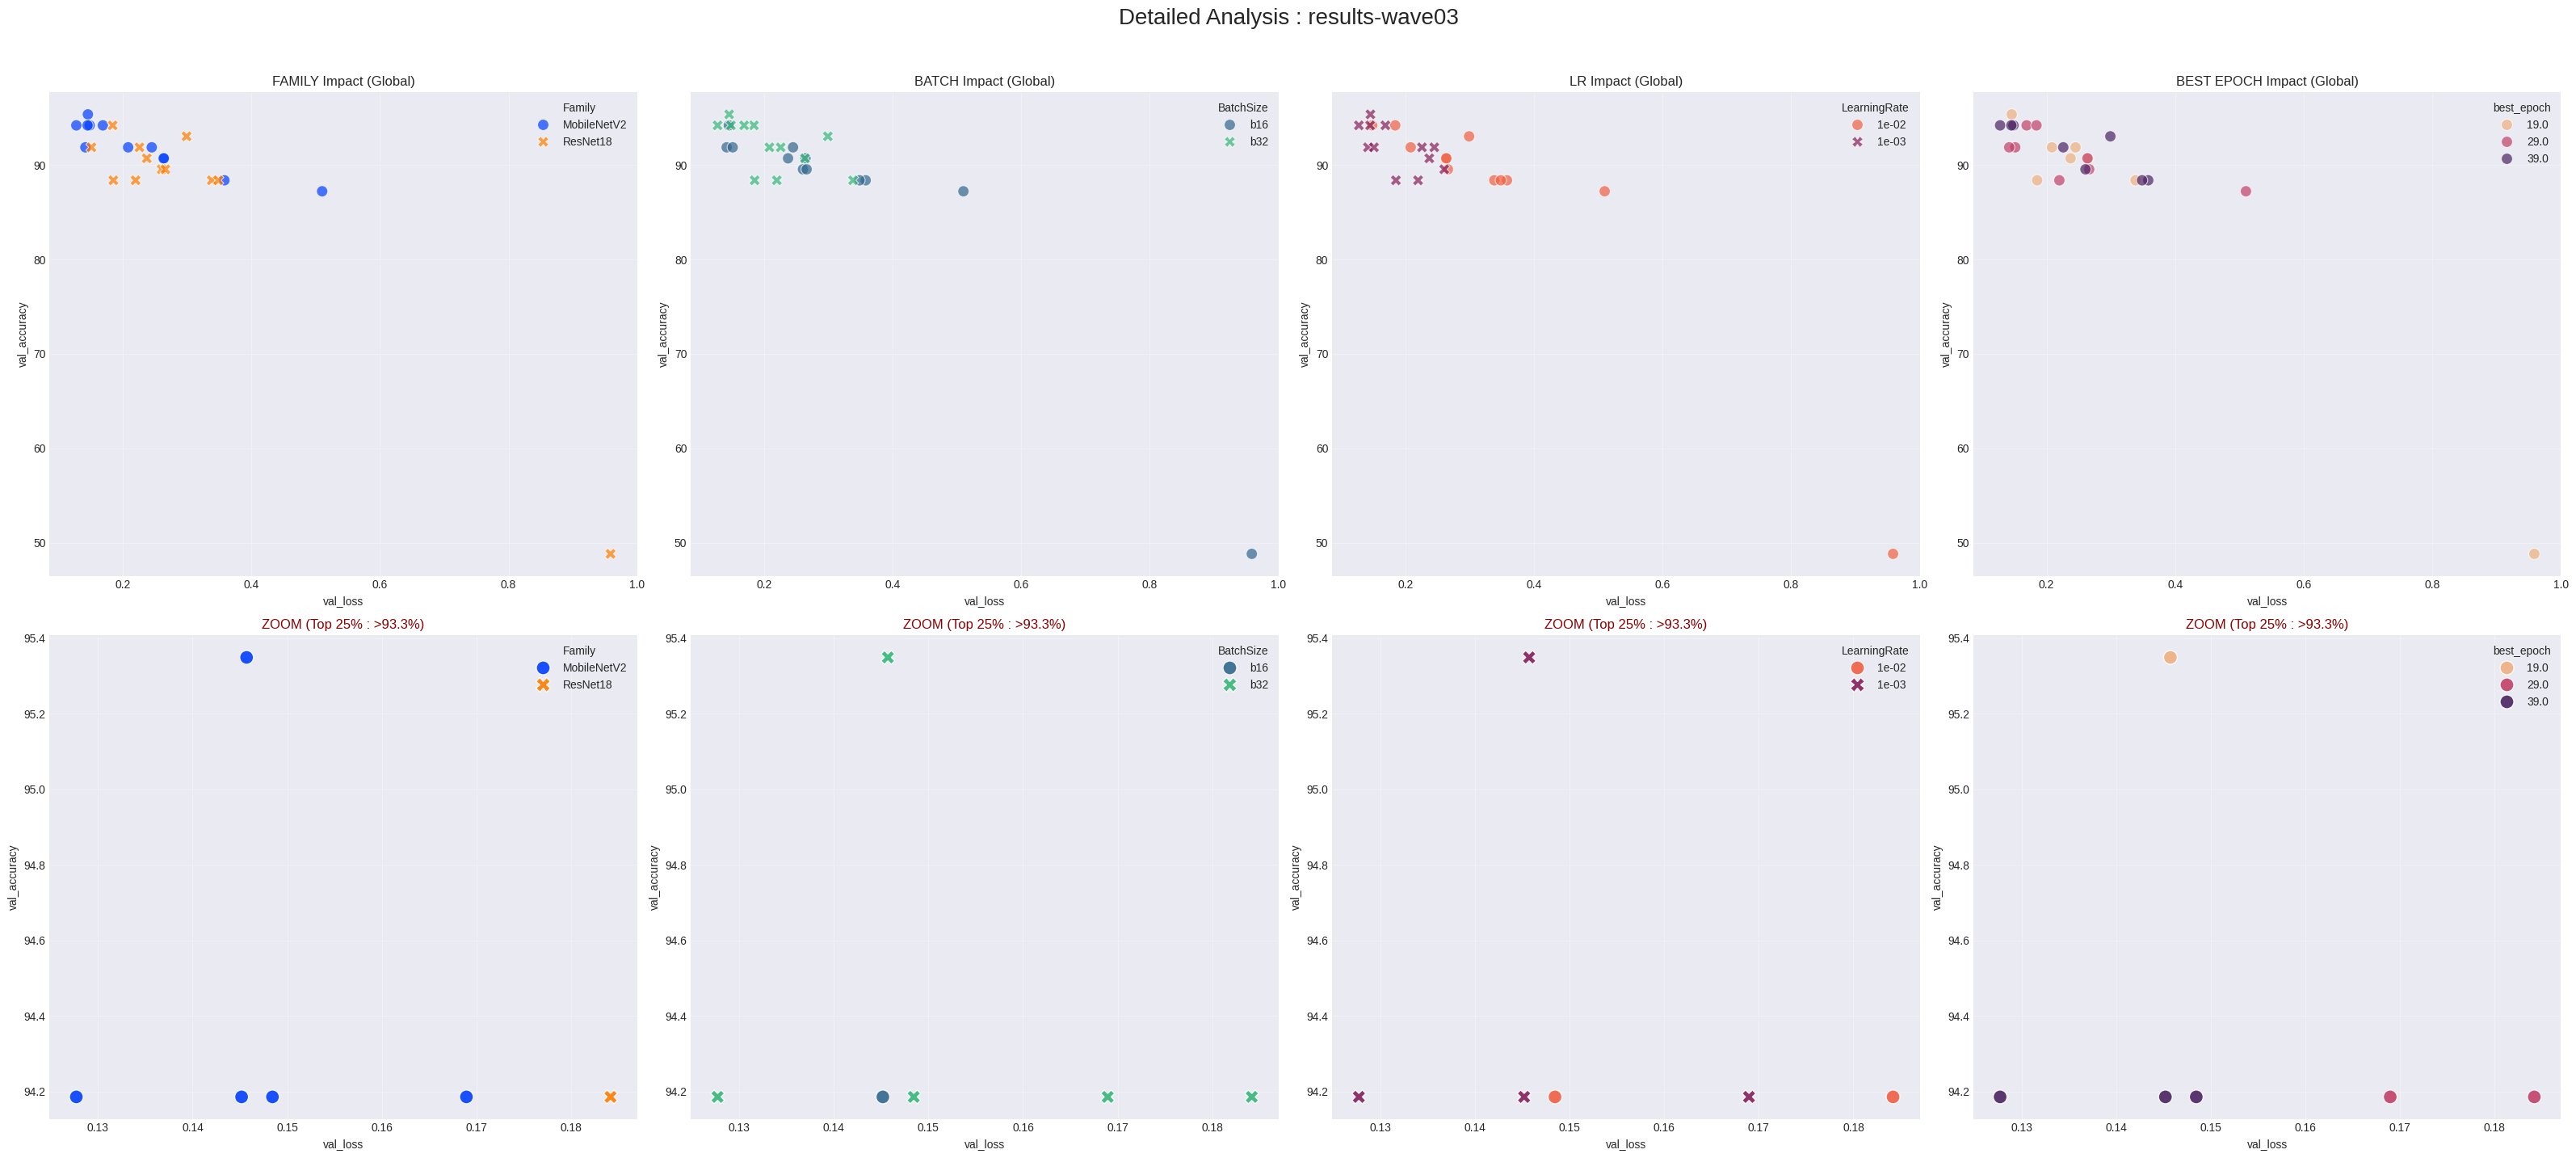

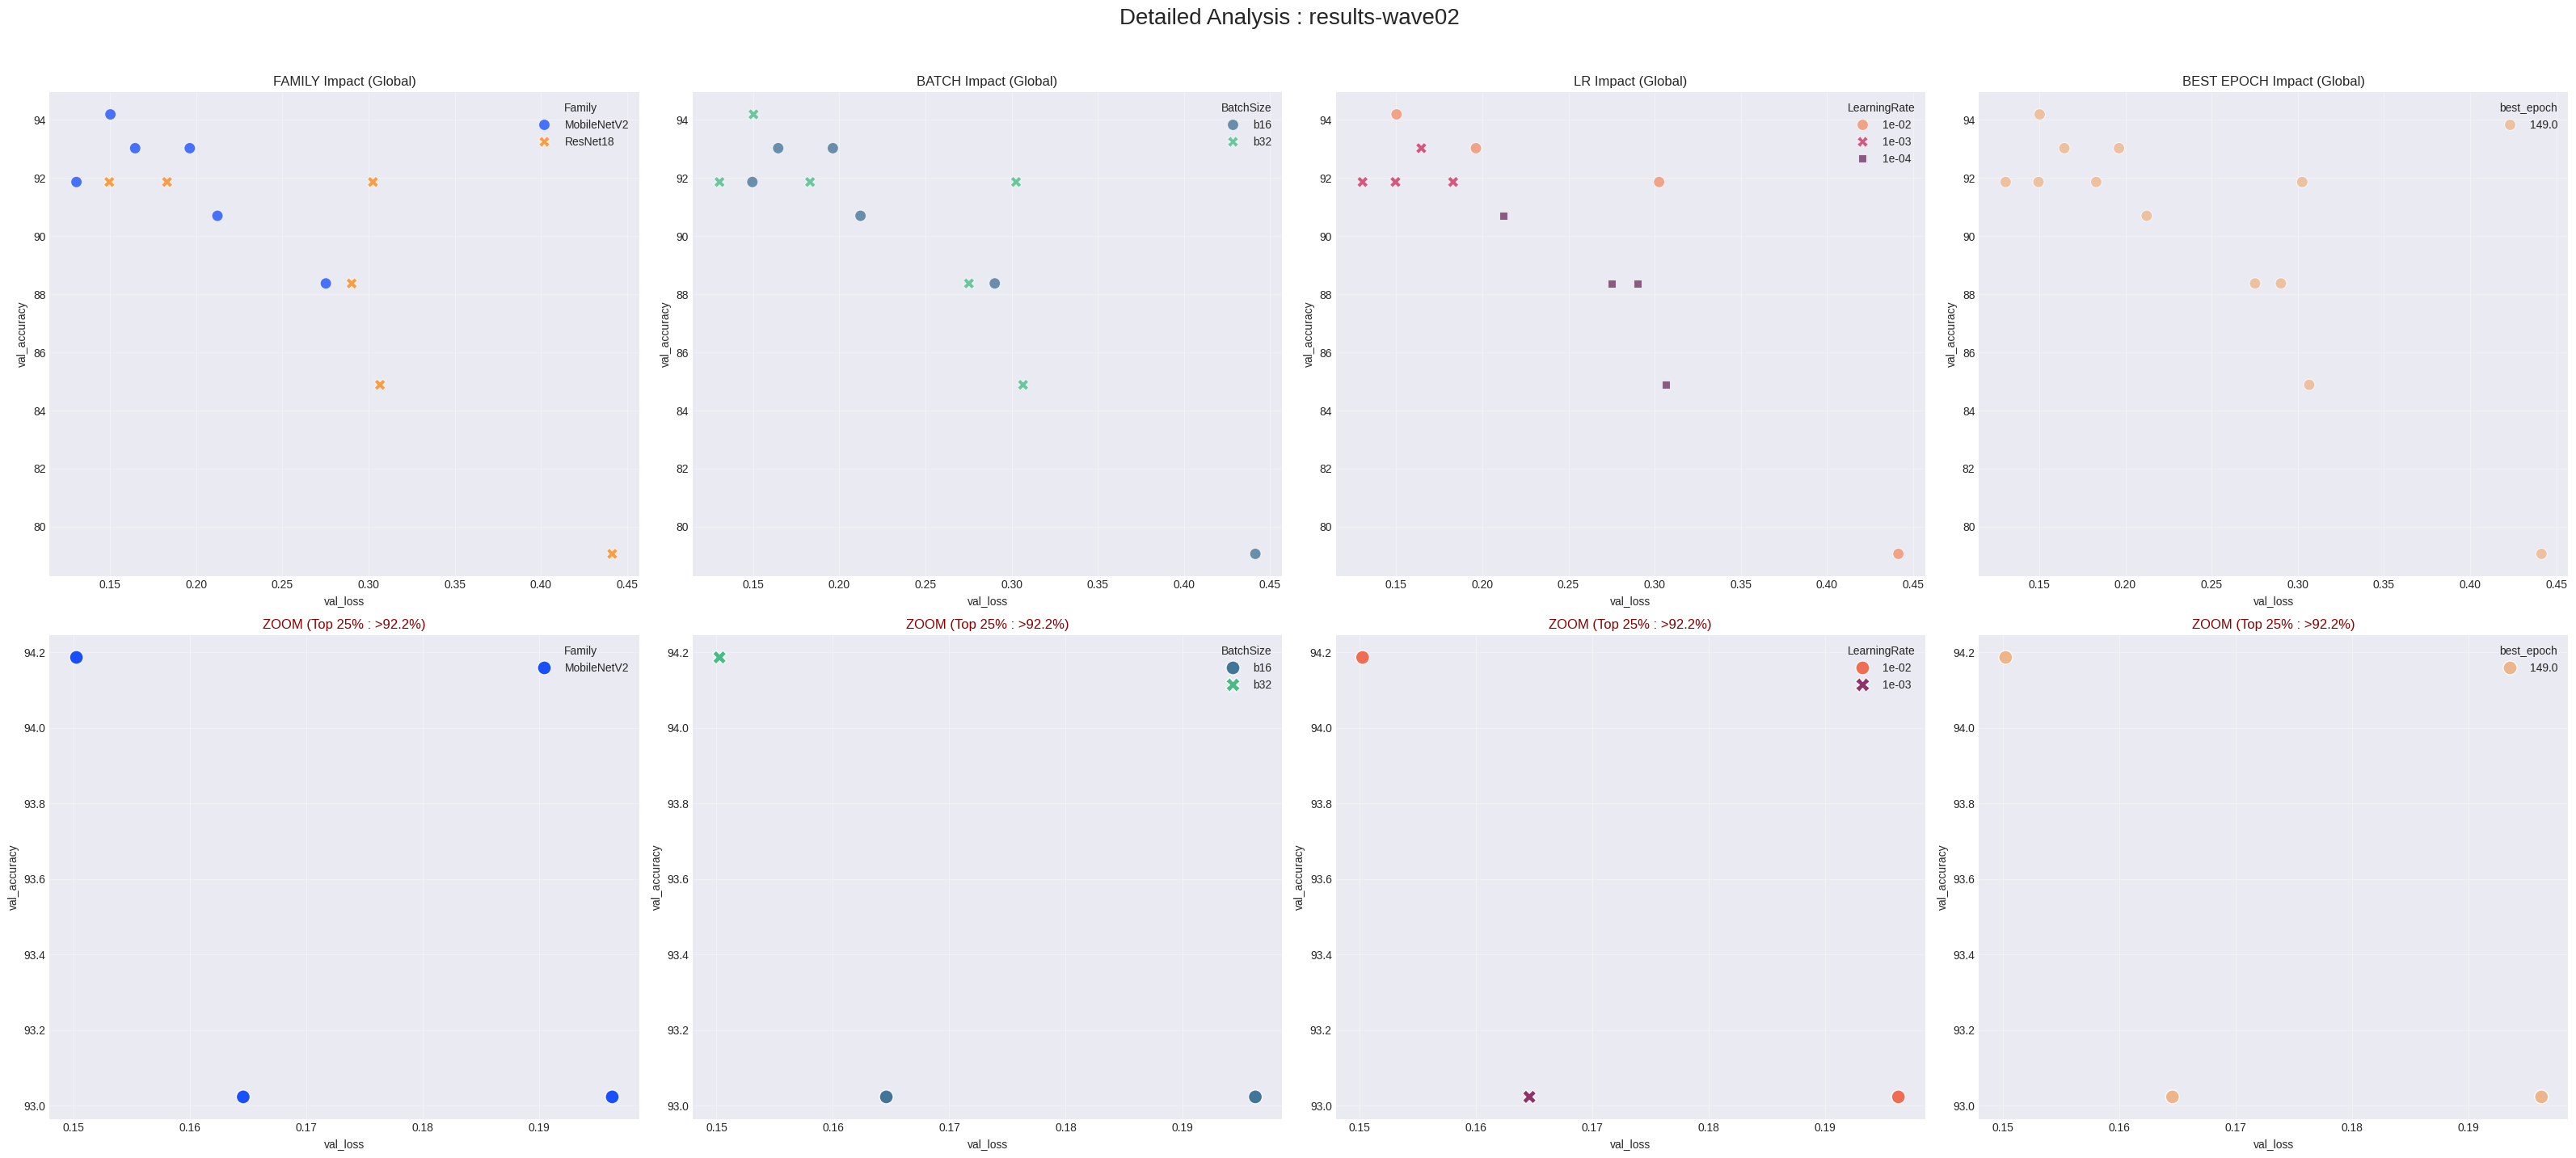

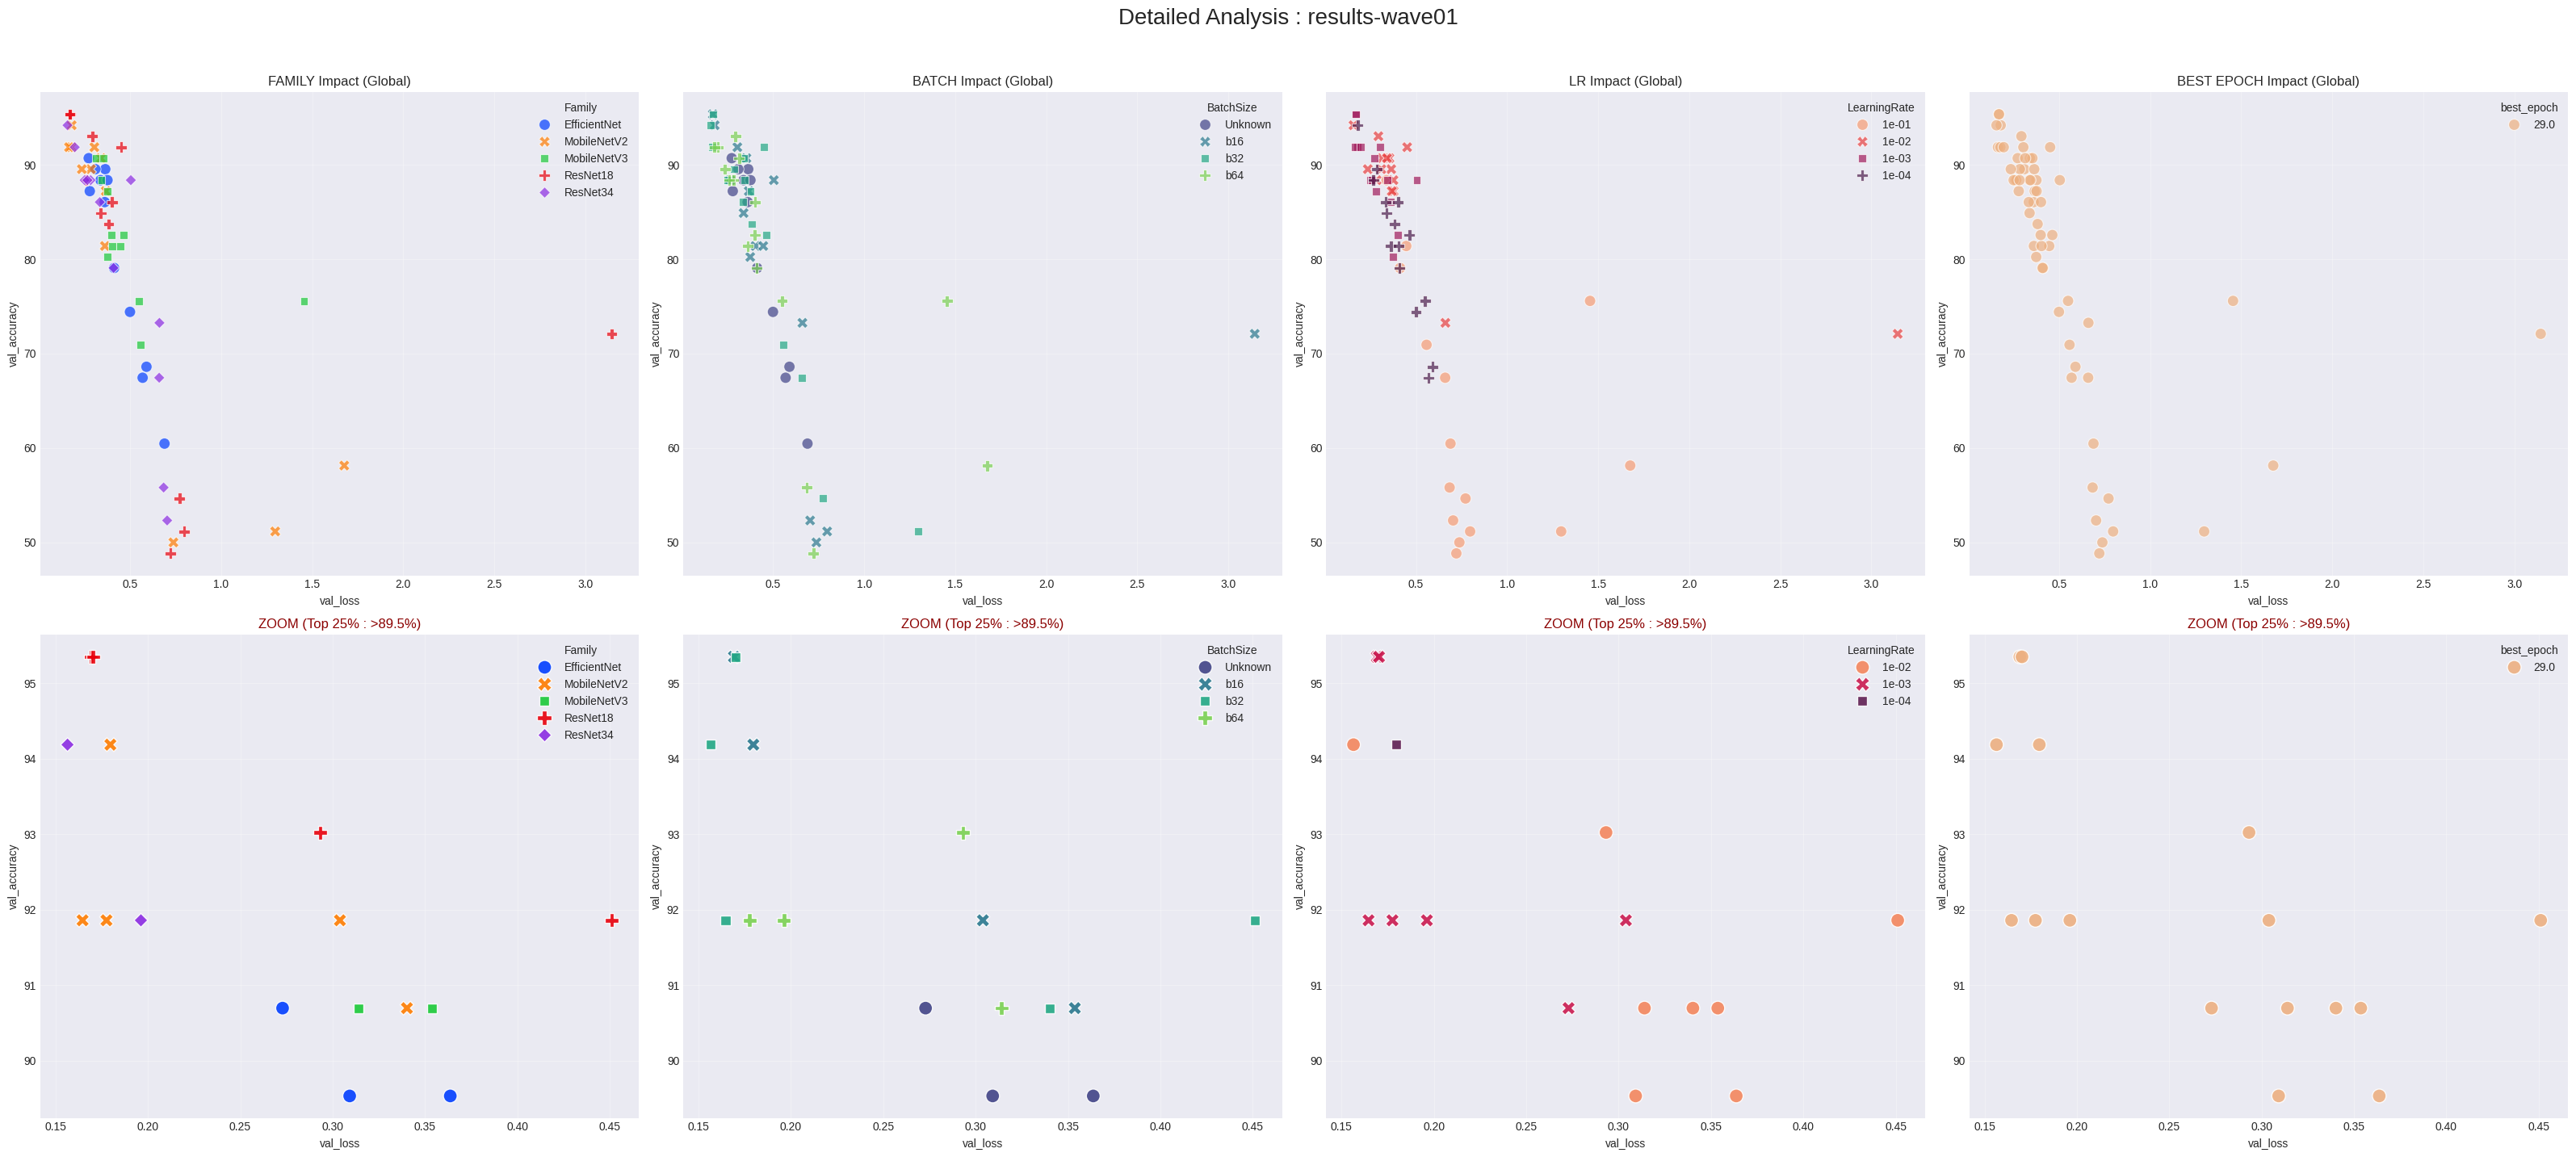

In [18]:
for version, full_df in all_results.items():
    # --- Chart 2: Detailed Grid ---
    acc_threshold = full_df['val_accuracy'].quantile(0.75)
    zoom_df = full_df[full_df['val_accuracy'] >= acc_threshold].copy()

    fig, axes = plt.subplots(2, 4, figsize=(32, 14))
    plot_configs = [
        {'col': 'Family',       'title': 'FAMILY Impact',    'palette': 'bright'},
        {'col': 'BatchSize',    'title': 'BATCH Impact',      'palette': 'viridis'},
        {'col': 'LearningRate', 'title': 'LR Impact',         'palette': 'rocket_r'},
        {'col': 'best_epoch',   'title': 'BEST EPOCH Impact', 'palette': 'flare'}
    ]
    
    for i, config in enumerate(plot_configs):
        col_name = config['col']
        current_full = full_df.sort_values(col_name)
        current_zoom = zoom_df.sort_values(col_name) if not zoom_df.empty else pd.DataFrame()
        style_param = col_name if col_name != 'best_epoch' else None

        # Top
        if not current_full.empty:
            sns.scatterplot(data=current_full, x='val_loss', y='val_accuracy', hue=col_name, style=style_param, s=100, alpha=0.7, palette=config['palette'], ax=axes[0, i])
            # Legend only if necessary
            if axes[0, i].legend_: axes[0, i].legend(title=col_name)
        axes[0, i].set_title(f"{config['title']} (Global)")
        axes[0, i].grid(True, alpha=0.3)

        # Bottom
        if not current_zoom.empty:
            sns.scatterplot(data=current_zoom, x='val_loss', y='val_accuracy', hue=col_name, style=style_param, s=150, alpha=0.9, palette=config['palette'], ax=axes[1, i])
            axes[1, i].set_title(f"ZOOM (Top 25% : >{acc_threshold:.1f}%)", color='darkred')
        else:
             axes[1, i].text(0.5, 0.5, "No data", ha='center')
        axes[1, i].grid(True, alpha=0.3)
        
    plt.suptitle(f"Detailed Analysis : {version}", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

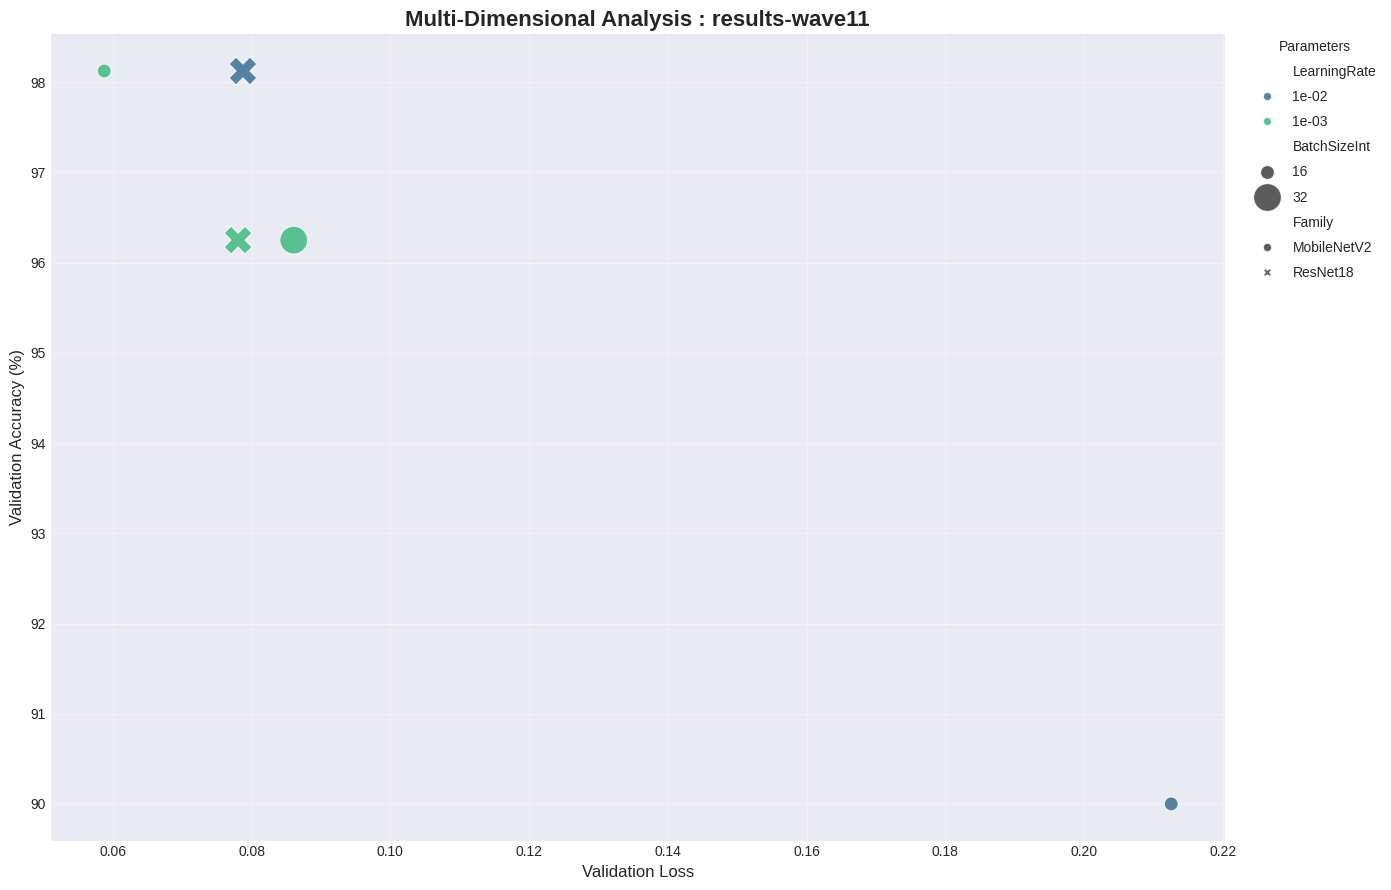

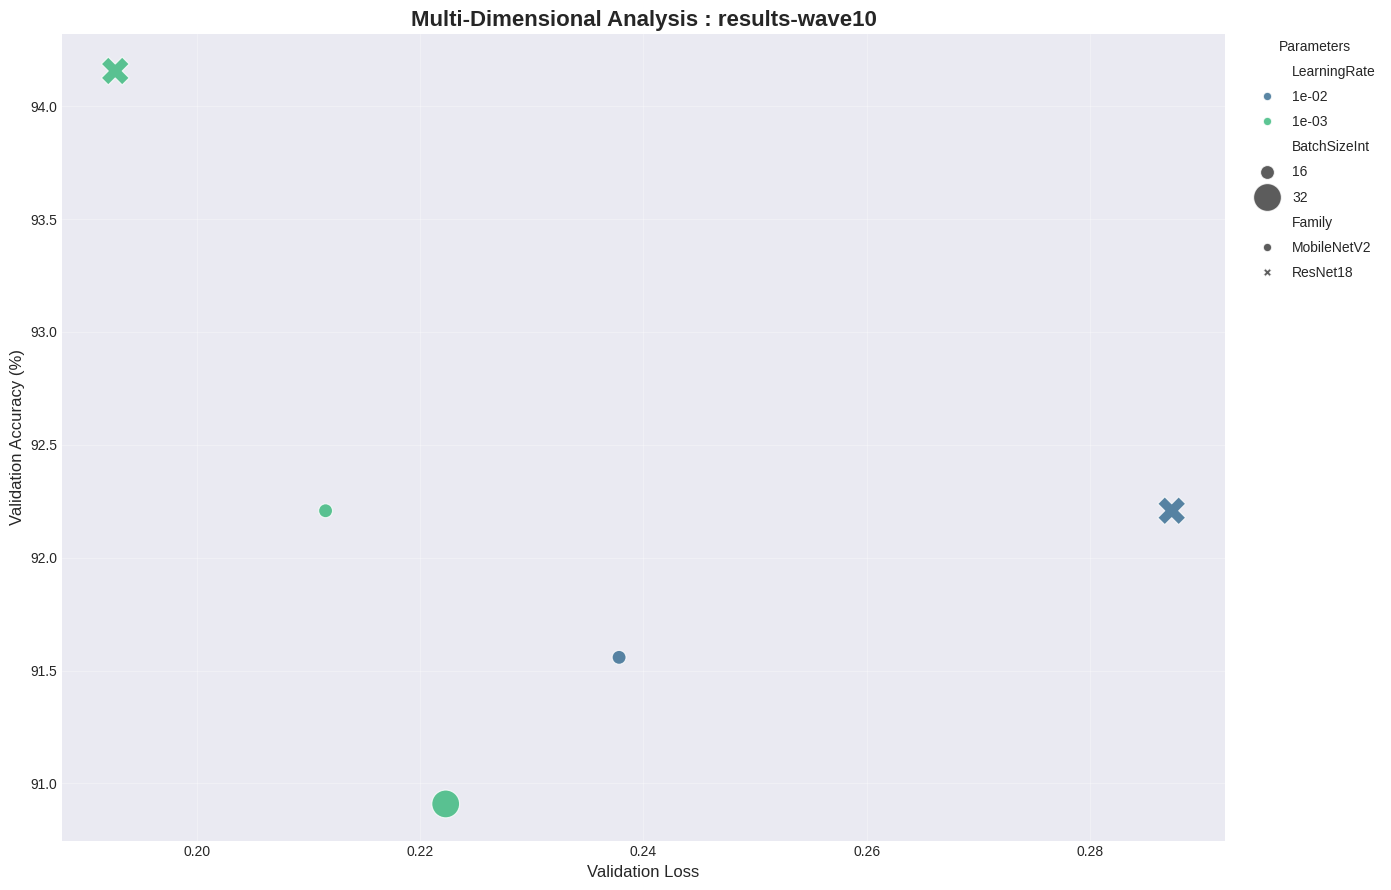

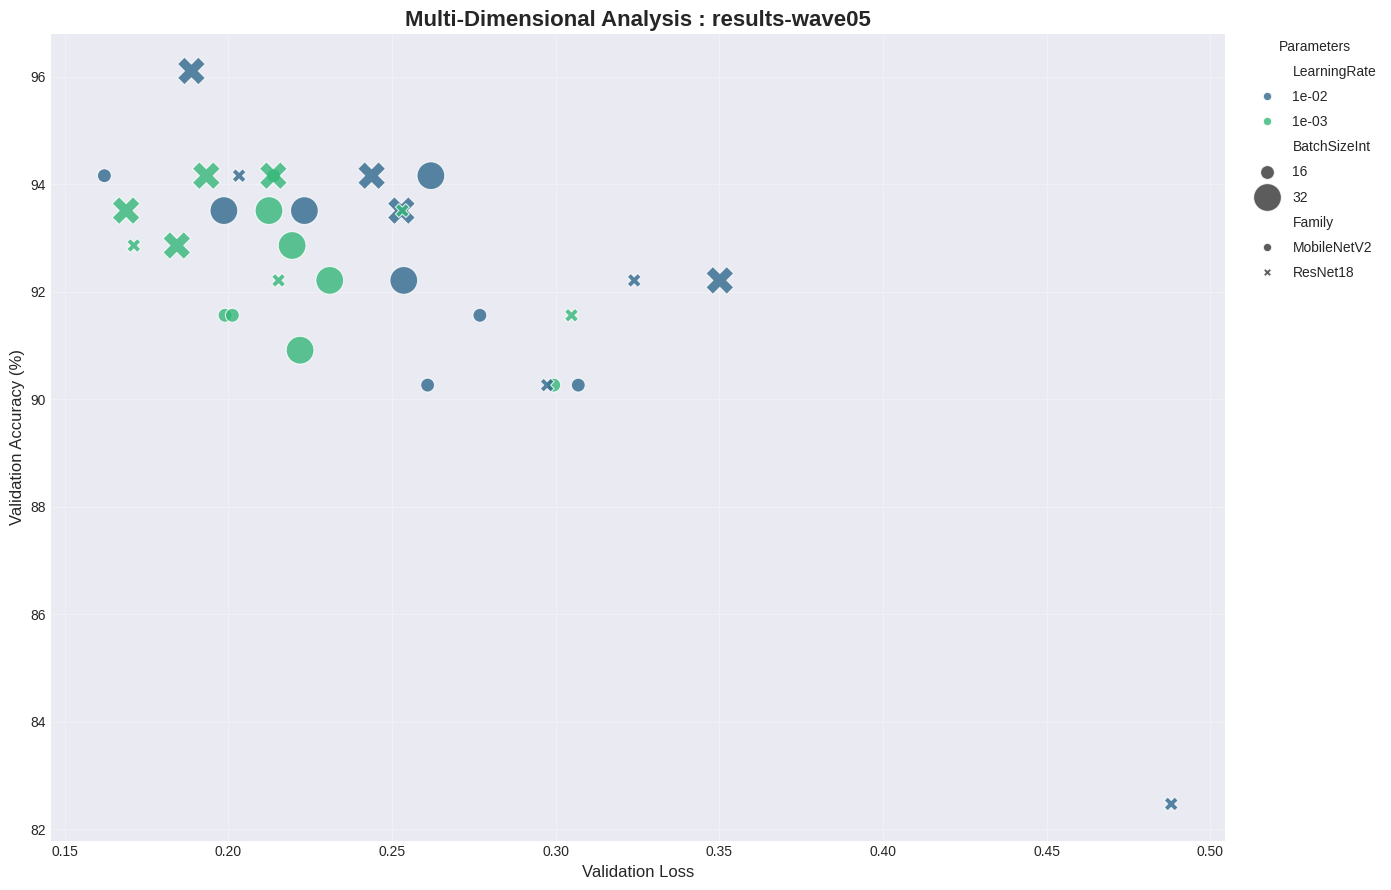

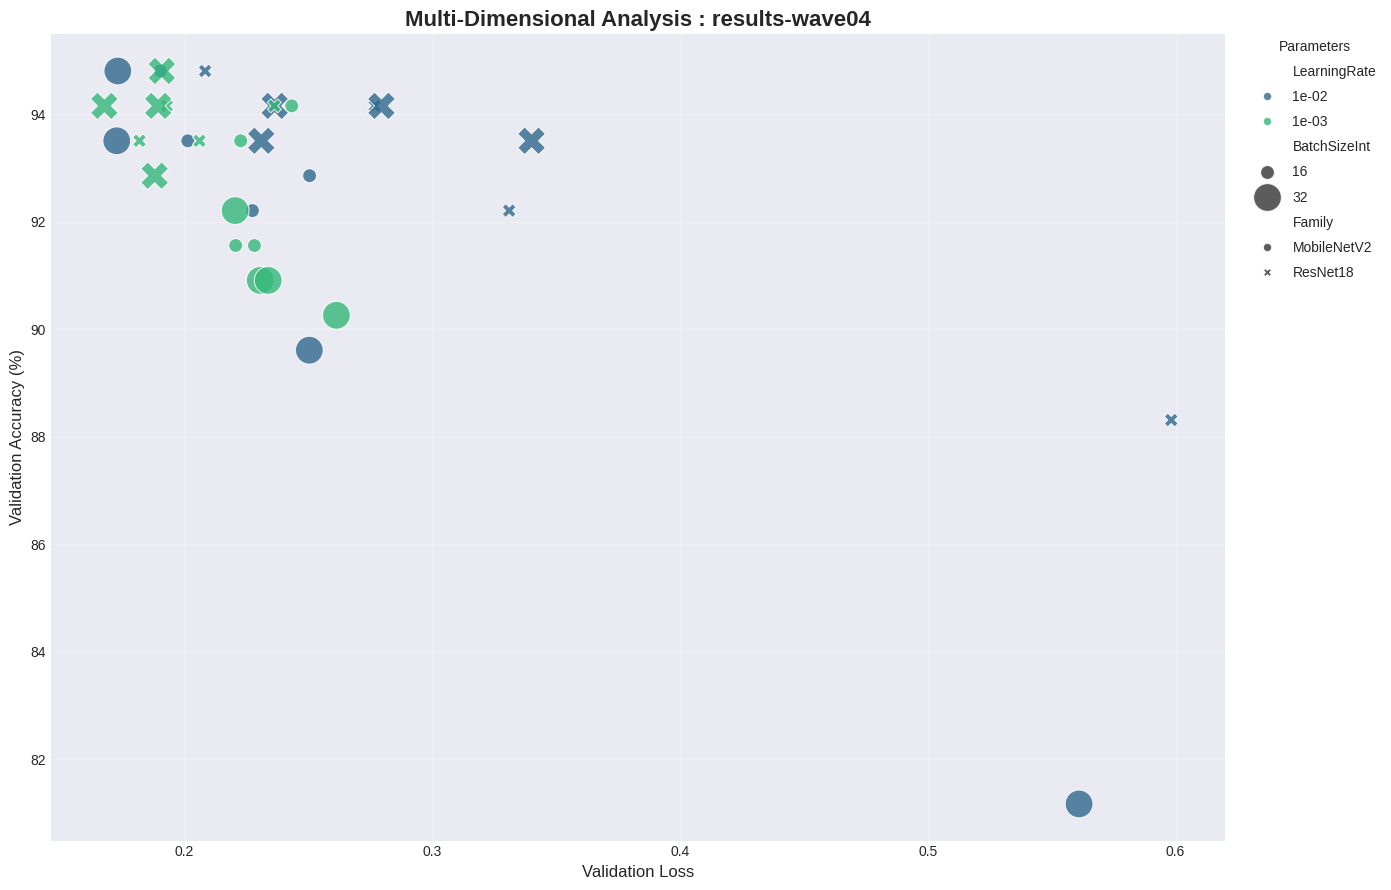

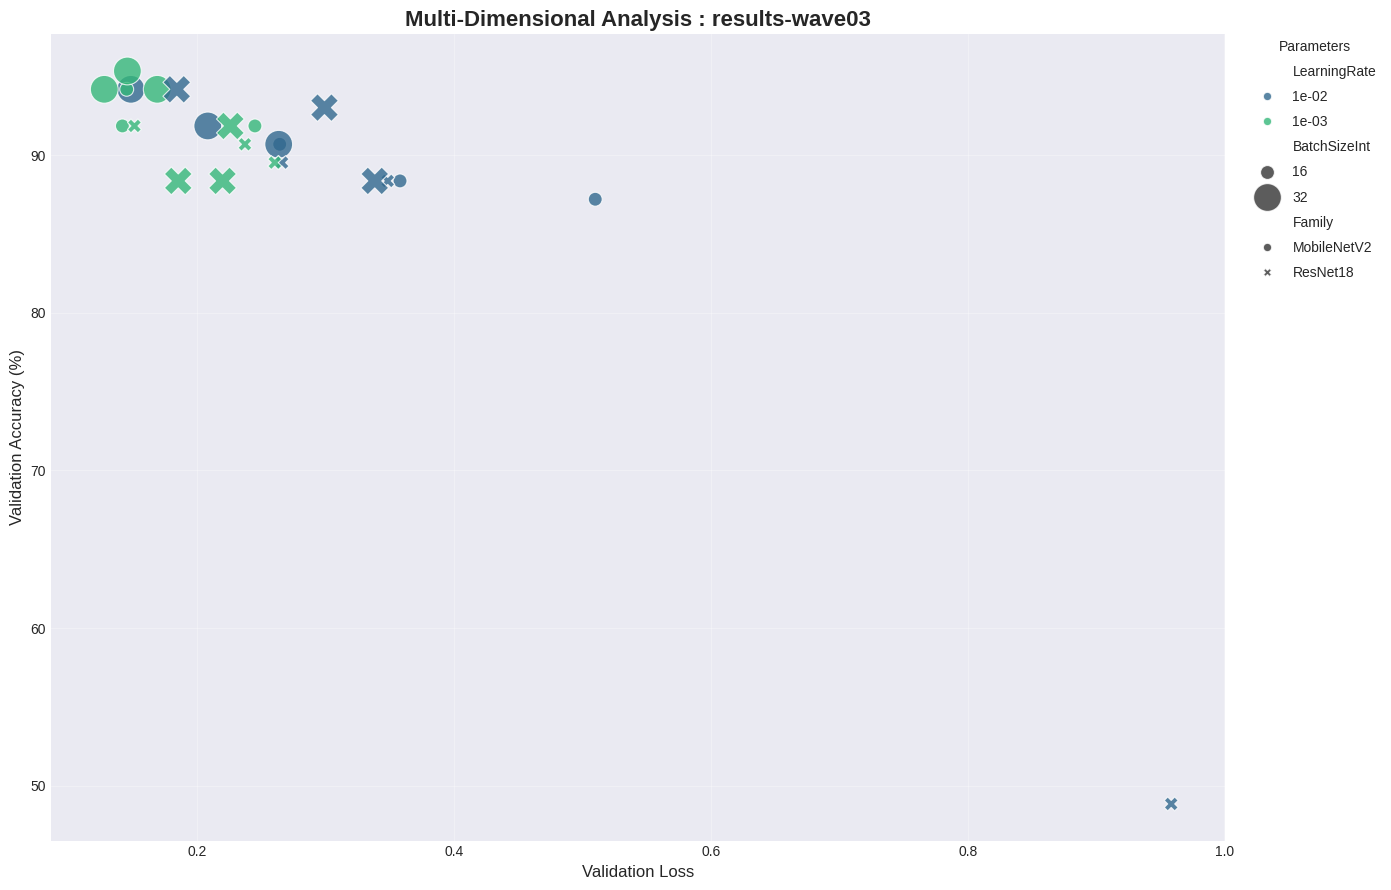

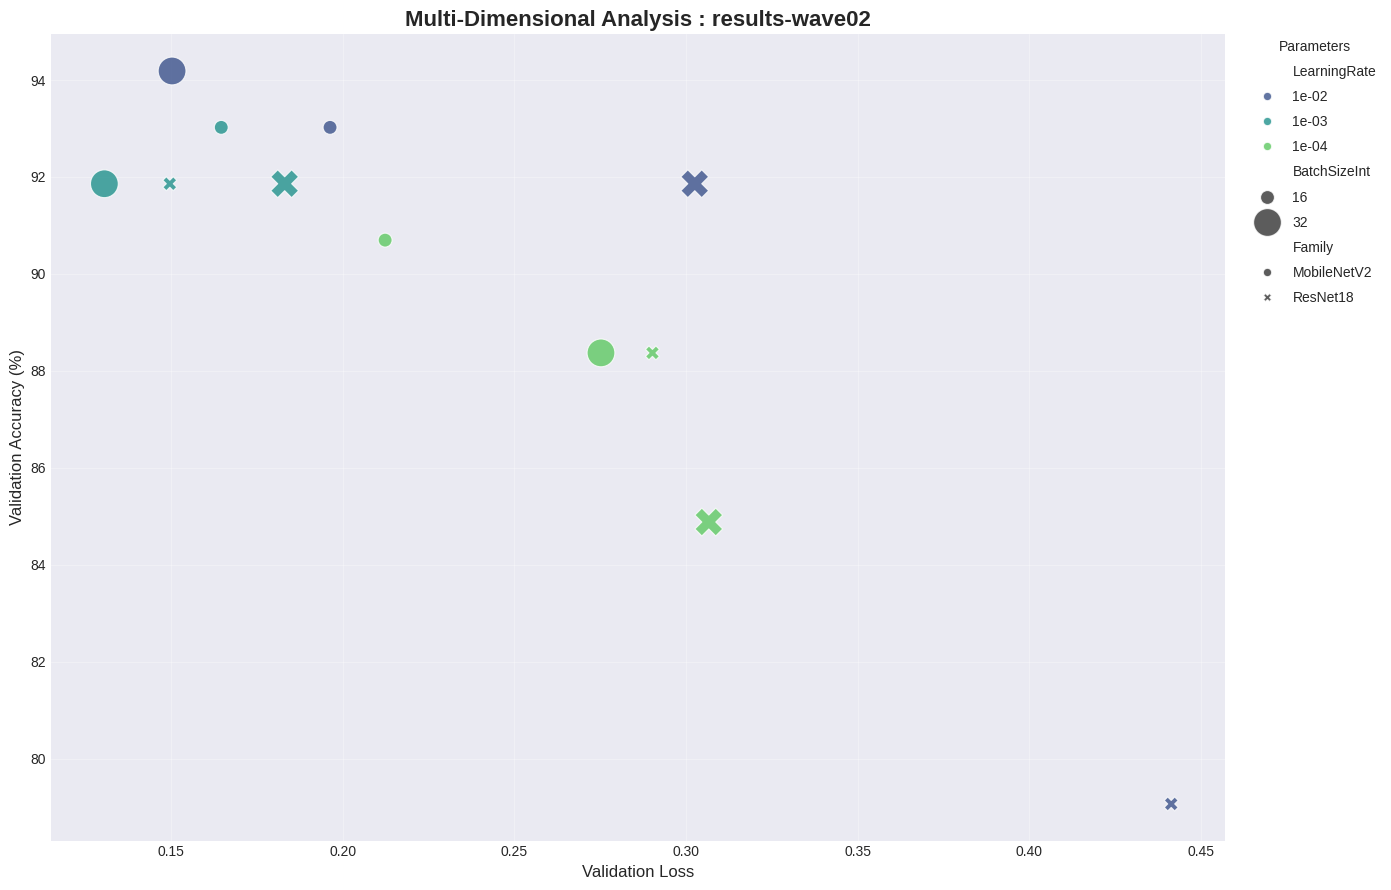

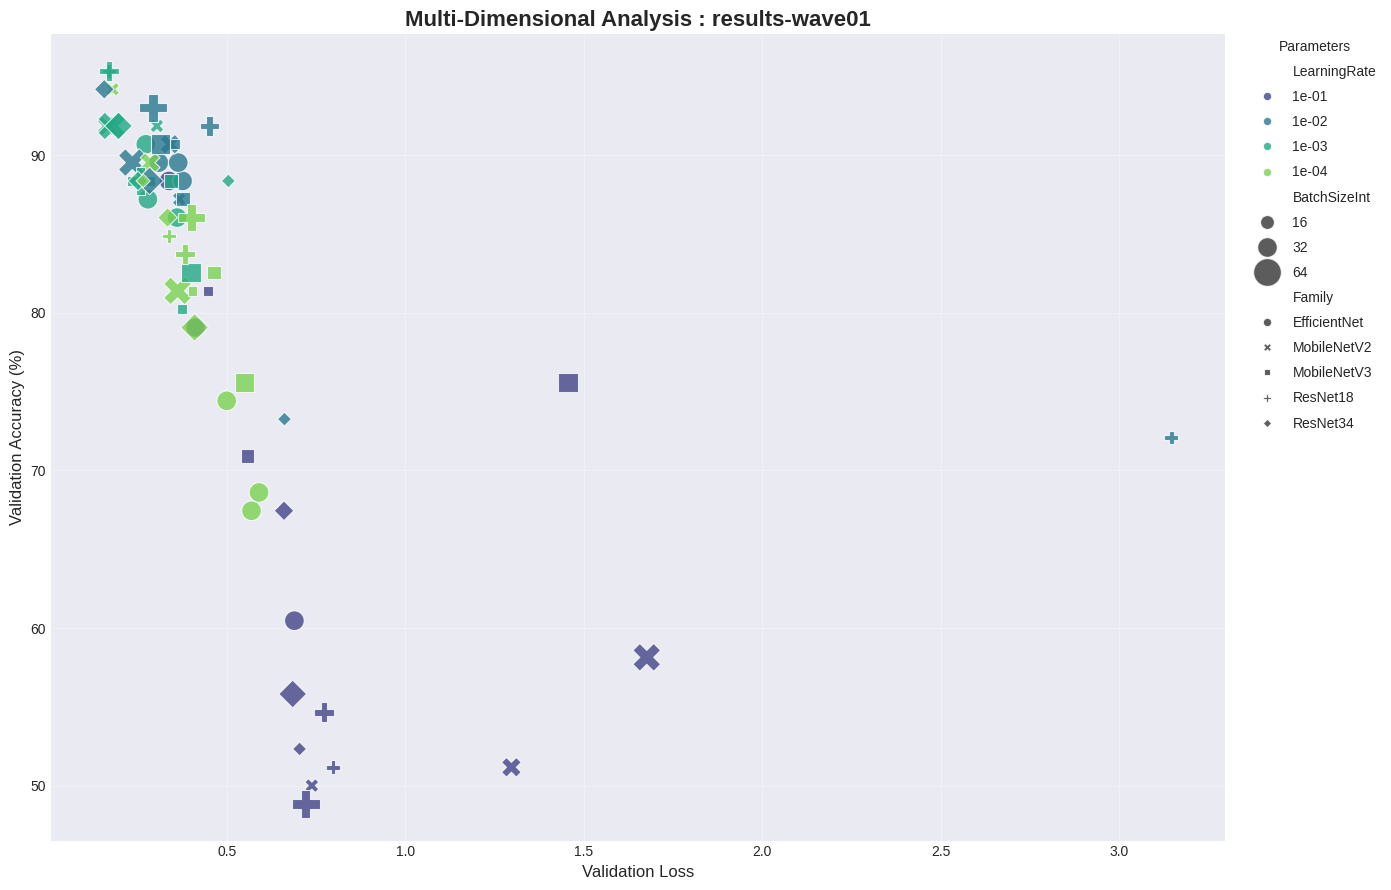

In [19]:
for version, full_df in all_results.items():
    # --- Chart 3: Multi-Dimensional Analysis ---
    plt.figure(figsize=(14, 9))
    
    # Ensure columns are present (BatchSize is sometimes a string 'b32', we want an integer for point size)
    # Temporary conversion for the chart
    plot_df = full_df.copy()
    
    # Clean BatchSize to have integers (necessary for seaborn 'size' parameter)
    def clean_batch_size(val):
        if isinstance(val, str) and val.startswith('b'):
            try: return int(val[1:])
            except: return 0
        return val if isinstance(val, (int, float)) else 32

    plot_df['BatchSizeInt'] = plot_df['BatchSize'].apply(clean_batch_size)
    
    # Sort for legend
    plot_df = plot_df.sort_values(by=['Family', 'LearningRate', 'BatchSizeInt'])

    sns.scatterplot(
        data=plot_df,
        x='val_loss', 
        y='val_accuracy',
        style='Family',       # SHAPE = Family
        hue='LearningRate',   # COLOR = Learning Rate
        size='BatchSizeInt',  # SIZE = Batch Size (integer)
        sizes=(100, 400),     # Size range of points
        palette='viridis',    # Palette
        alpha=0.8
    )

    plt.xlabel('Validation Loss', fontsize=12)
    plt.ylabel('Validation Accuracy (%)', fontsize=12)
    plt.title(f'Multi-Dimensional Analysis : {version}', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Optimized legend outside
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., labelspacing=0.8, title="Parameters")

    plt.tight_layout()
    plt.show()

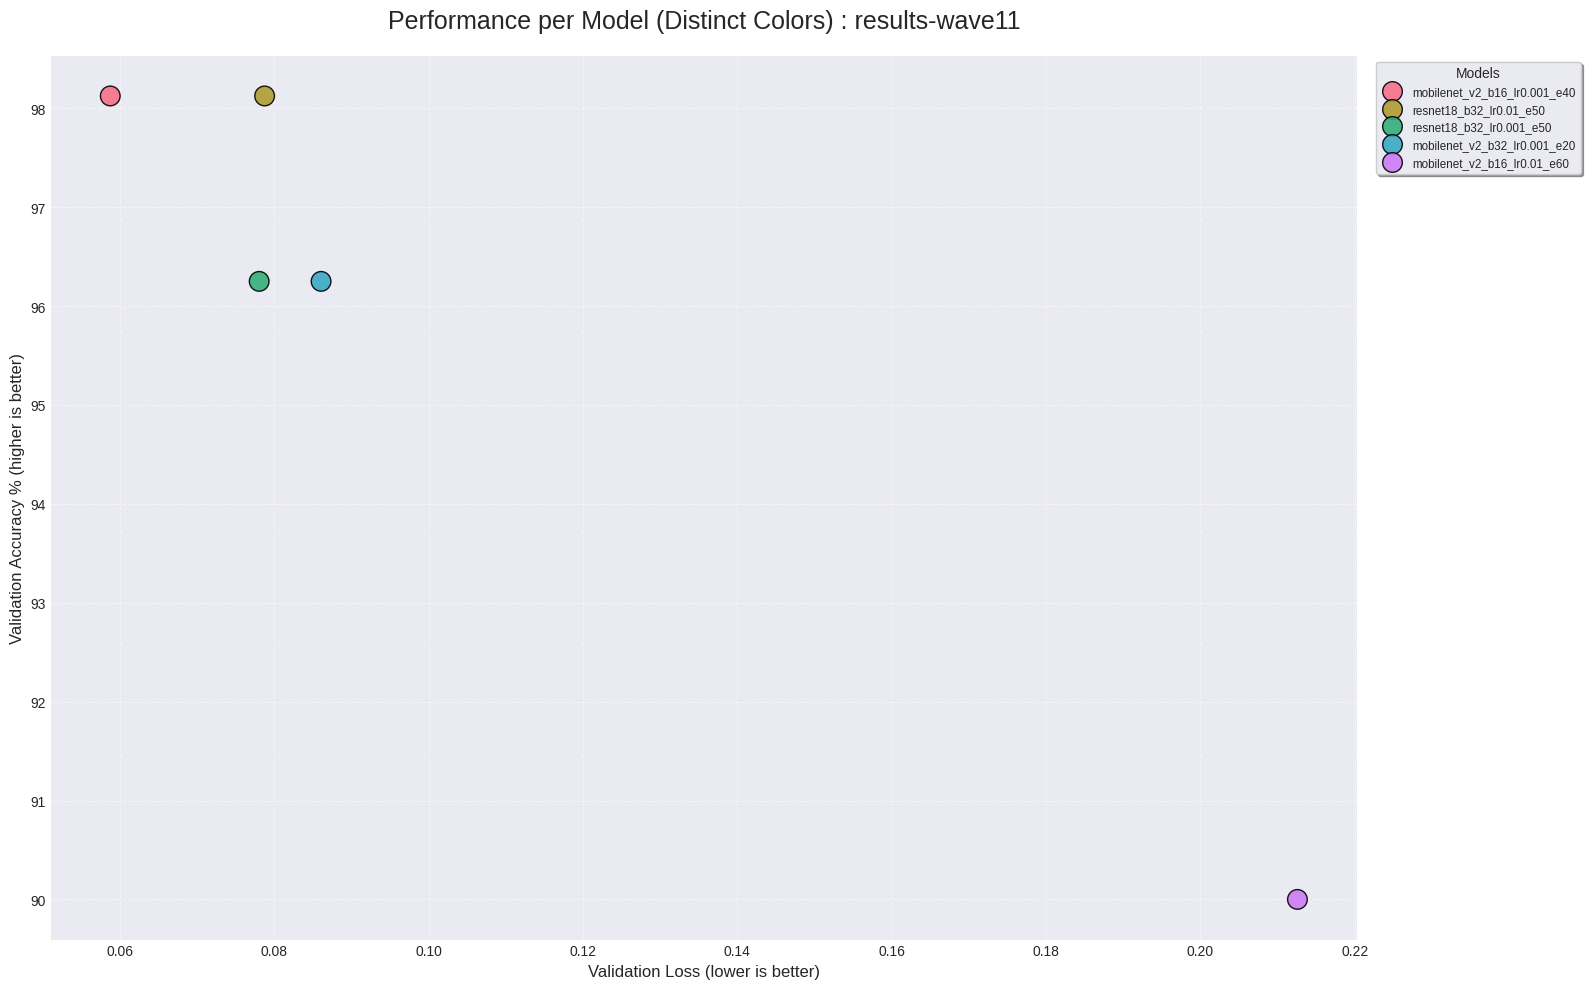

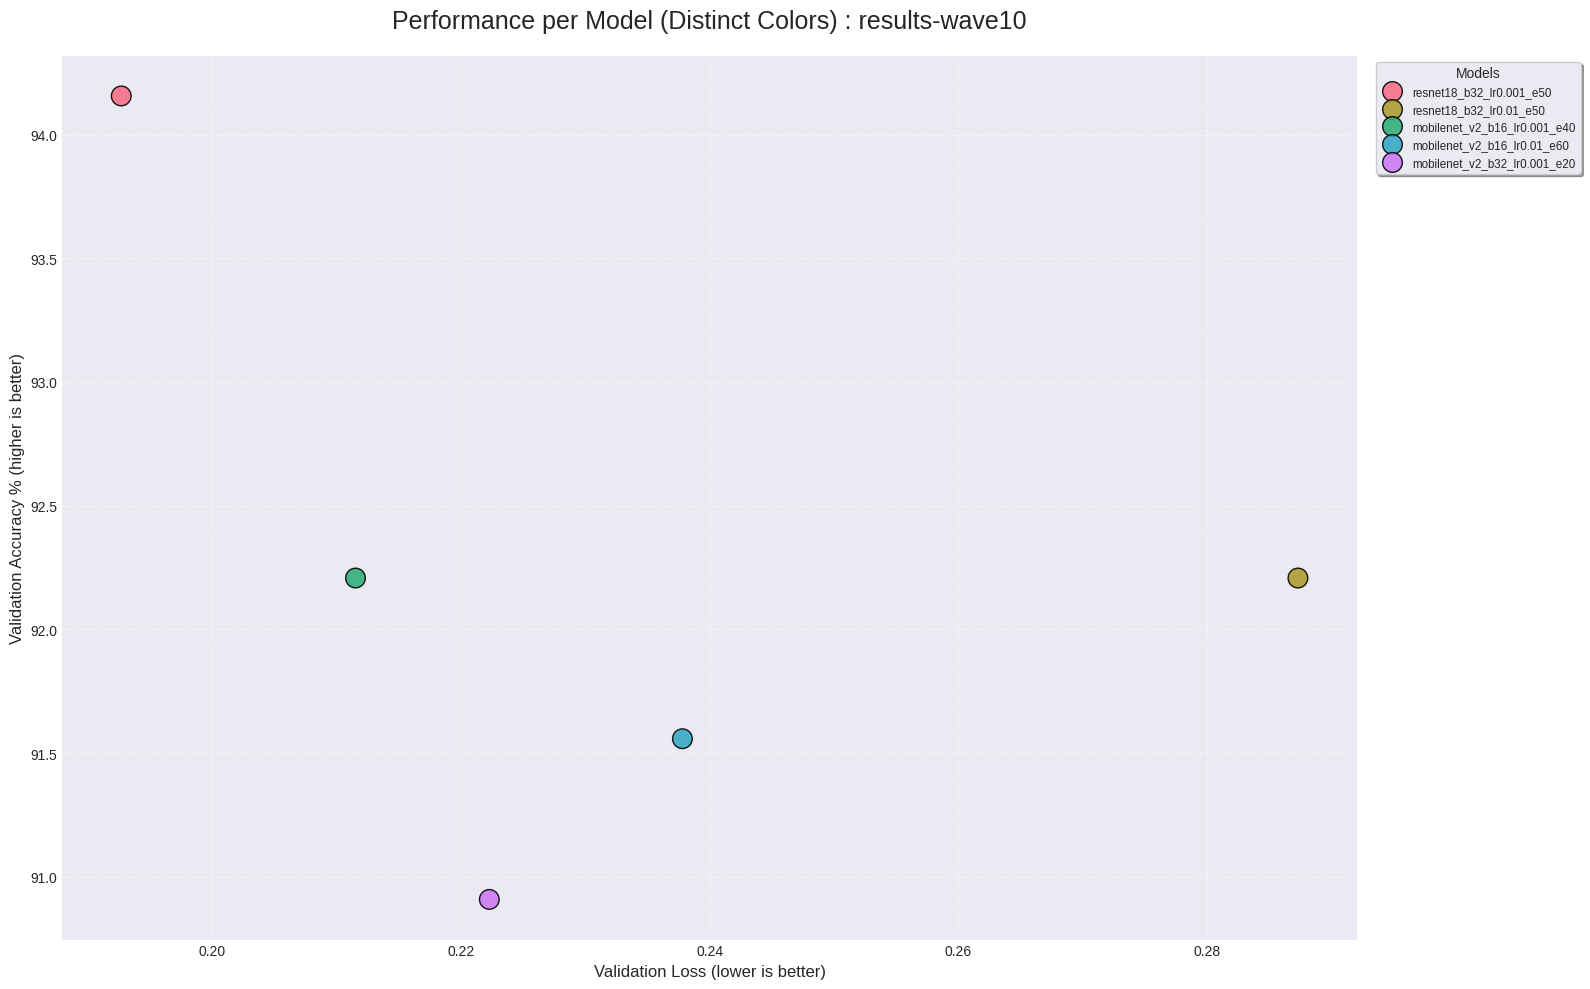

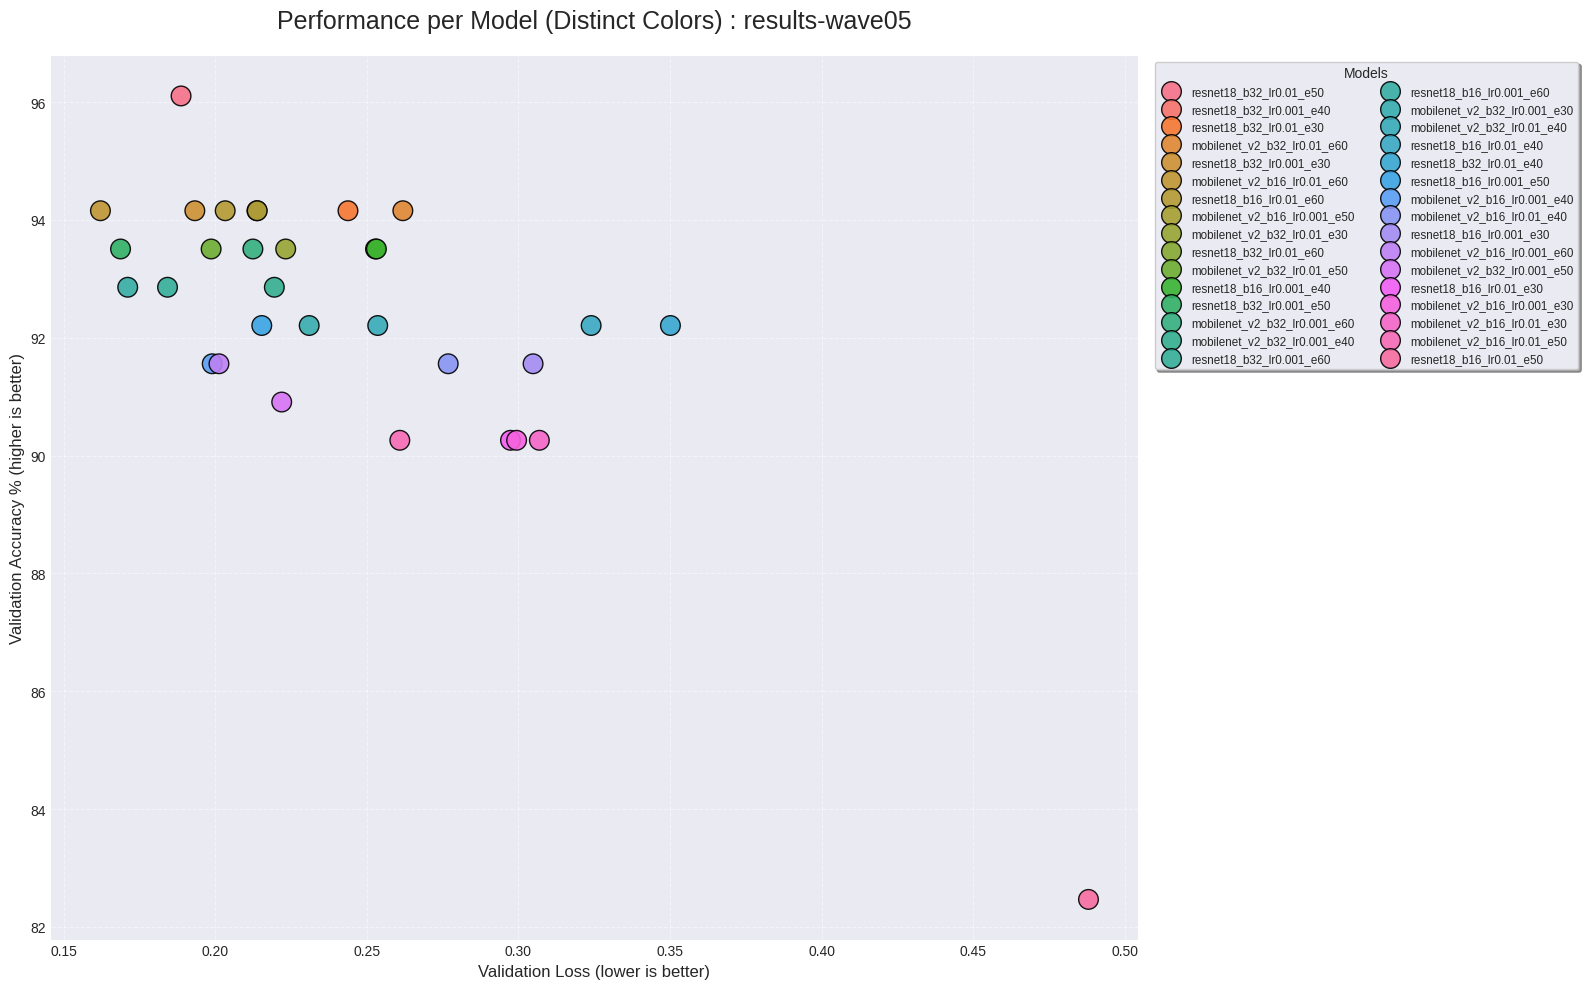

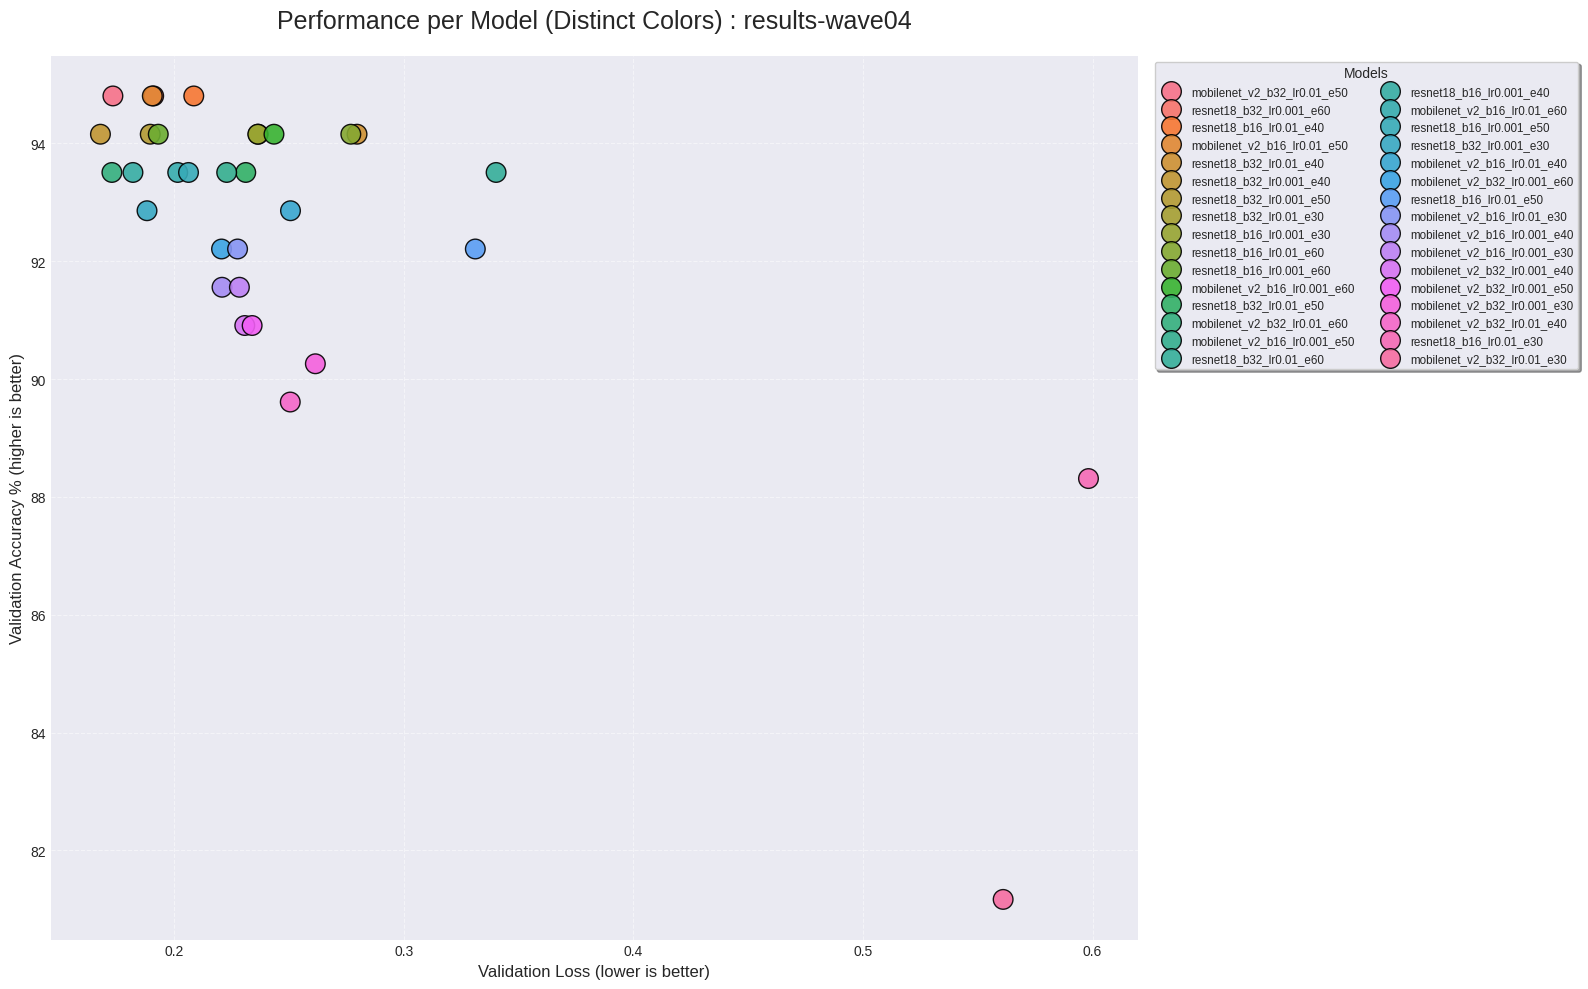

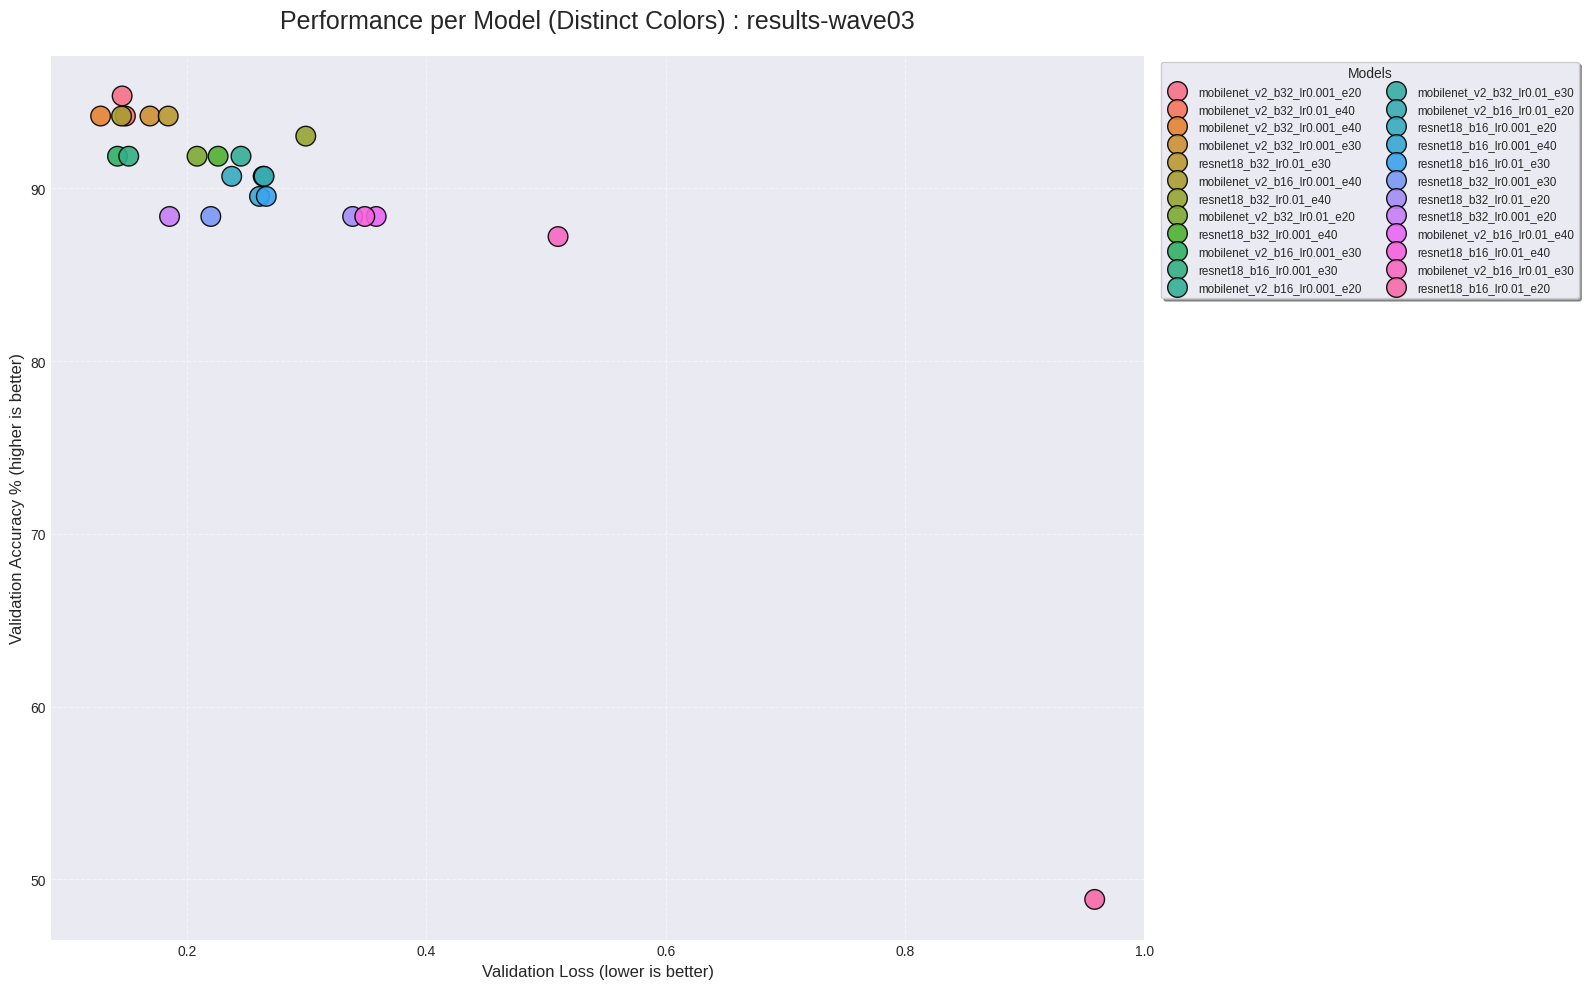

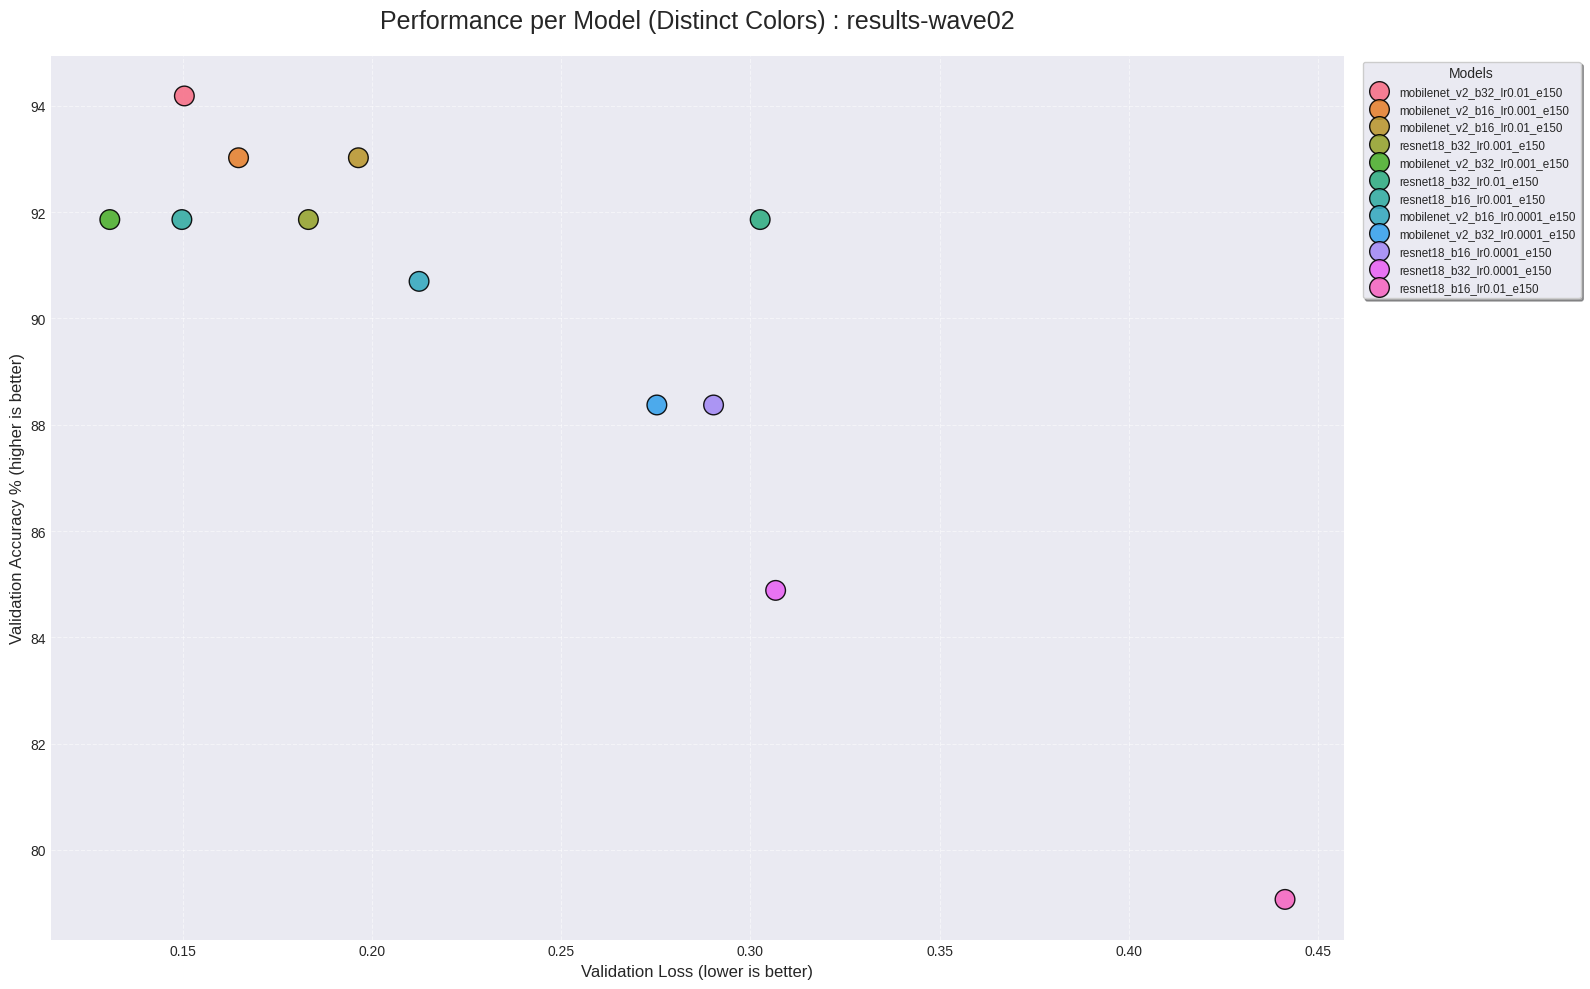

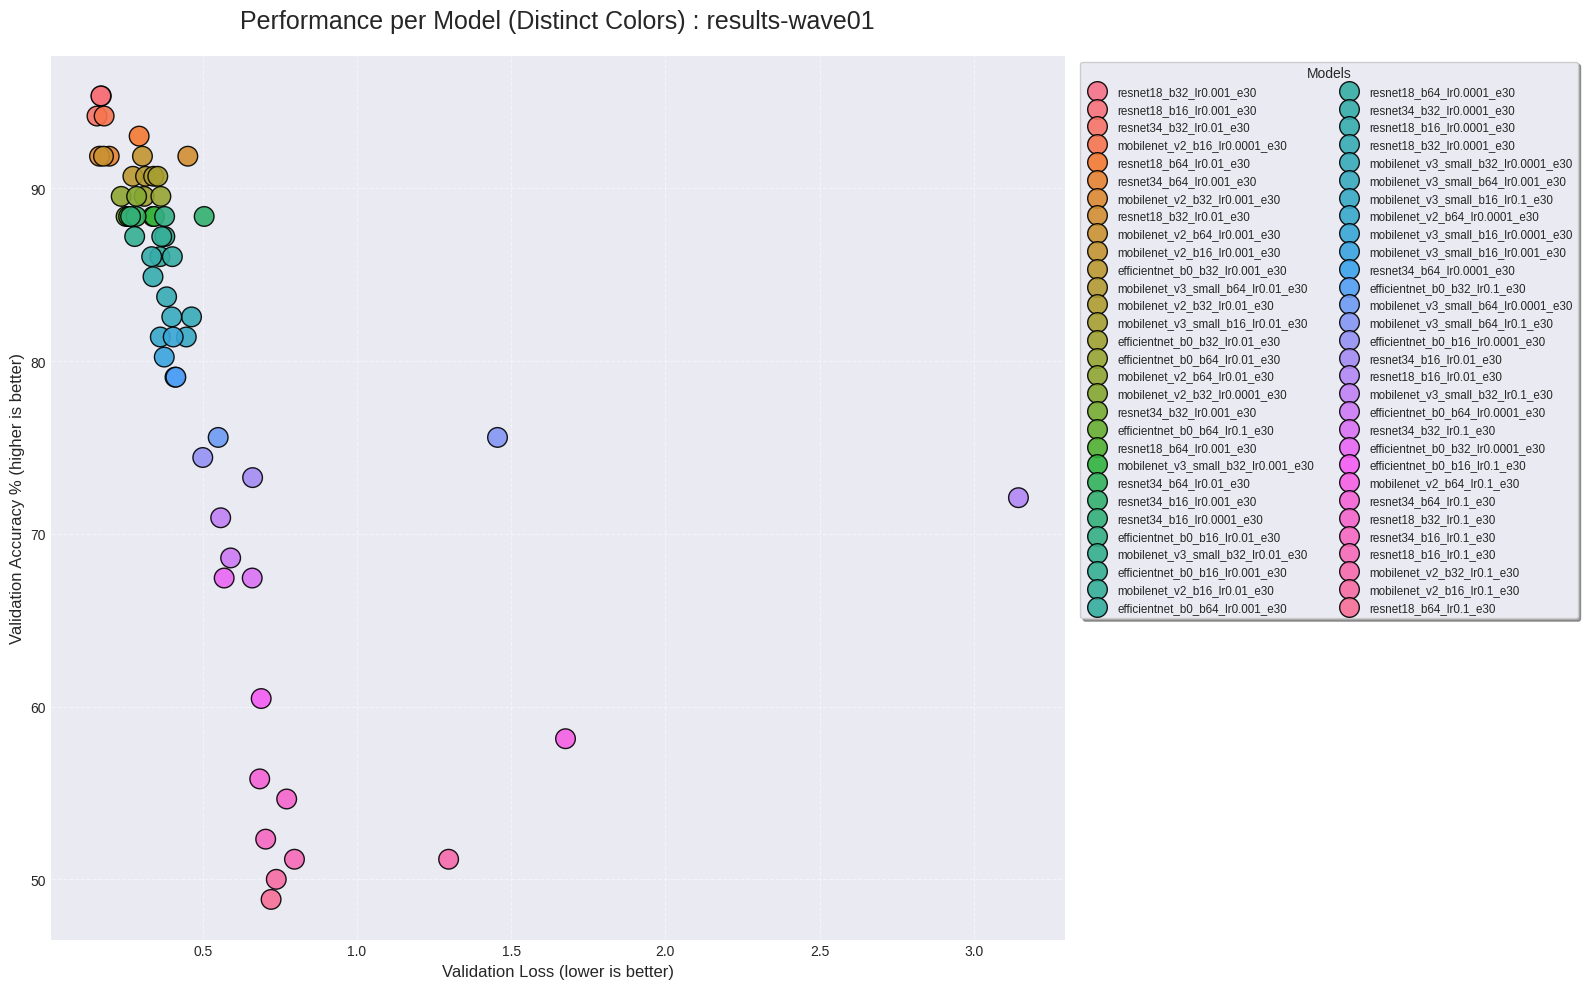

In [20]:
for version, full_df in all_results.items():
    plt.figure(figsize=(16, 10))
    
    # 1. Sort models by performance
    ranked_df = full_df.sort_values(
        by=['val_accuracy', 'val_loss'], 
        ascending=[False, True]
    )
    
    # 2. Create chart with distinct colors
    # Create a palette with as many distinct colors as models
    n_models = len(ranked_df)
    # 'husl' allows equidistant colors in the visible spectrum
    distinct_palette = sns.color_palette("husl", n_models) 
    
    sns.scatterplot(
        data=ranked_df,
        x='val_loss', 
        y='val_accuracy',
        hue=ranked_df.index,
        hue_order=ranked_df.index,
        palette=distinct_palette, # Distinct Palette
        s=200,
        edgecolor='black',
        linewidth=1,
        alpha=0.9
    )
    
    # 3. Annotations for Top 10
    # for i, (model_name, row) in enumerate(ranked_df.head(10).iterrows()):
    #      plt.annotate(
    #         f"{i+1}. {model_name}", 
    #         (row['val_loss'], row['val_accuracy']),
    #         xytext=(10, 10), textcoords='offset points',
    #         fontsize=9, fontweight='bold',
    #         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    #     )

    plt.title(f"Performance per Model (Distinct Colors) : {version}", fontsize=18, pad=20)
    plt.xlabel("Validation Loss (lower is better)", fontsize=12)
    plt.ylabel("Validation Accuracy % (higher is better)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Legend placed outside
    plt.legend(
        bbox_to_anchor=(1.01, 1), 
        loc='upper left', 
        title="Models", 
        fontsize='small',
        frameon=True,
        shadow=True,
        ncol=1 if n_models < 20 else 2 # Two columns if many models
    )
    
    plt.tight_layout()
    plt.show()

In [21]:
# 1. Merge all data into a single DataFrame
global_list = []
for version, df in all_results.items():
    temp_df = df.copy()
    temp_df['Version'] = version  # Version identification
    global_list.append(temp_df)

if global_list:
    global_df = pd.concat(global_list)

    # 2. Global Sort: Maximize Accuracy, Minimize Loss
    global_ranked = global_df.sort_values(
        by=['val_accuracy', 'val_loss'], 
        ascending=[False, True]
    ).head(TOP_N)


 ABSOLUTE GLOBAL RANKING (Top 15 out of 15 models)

                              val_accuracy  val_loss         Version  \
mobilenet_v2_b16_lr0.001_e40       98.1250    0.0588  results-wave11   
resnet18_b32_lr0.01_e50            98.1250    0.0788  results-wave11   
resnet18_b32_lr0.001_e50           96.2500    0.0781  results-wave11   
mobilenet_v2_b32_lr0.001_e20       96.2500    0.0861  results-wave11   
resnet18_b32_lr0.01_e50            96.1039    0.1887  results-wave05   
mobilenet_v2_b32_lr0.001_e20       95.3488    0.1457  results-wave03   
resnet18_b32_lr0.001_e30           95.3488    0.1703  results-wave01   
resnet18_b16_lr0.001_e30           95.3488    0.1691  results-wave01   
mobilenet_v2_b32_lr0.01_e50        94.8052    0.1733  results-wave04   
resnet18_b32_lr0.001_e60           94.8052    0.1911  results-wave04   
resnet18_b16_lr0.01_e40            94.8052    0.2085  results-wave04   
mobilenet_v2_b16_lr0.01_e50        94.8052    0.1905  results-wave04   
mobilenet_v

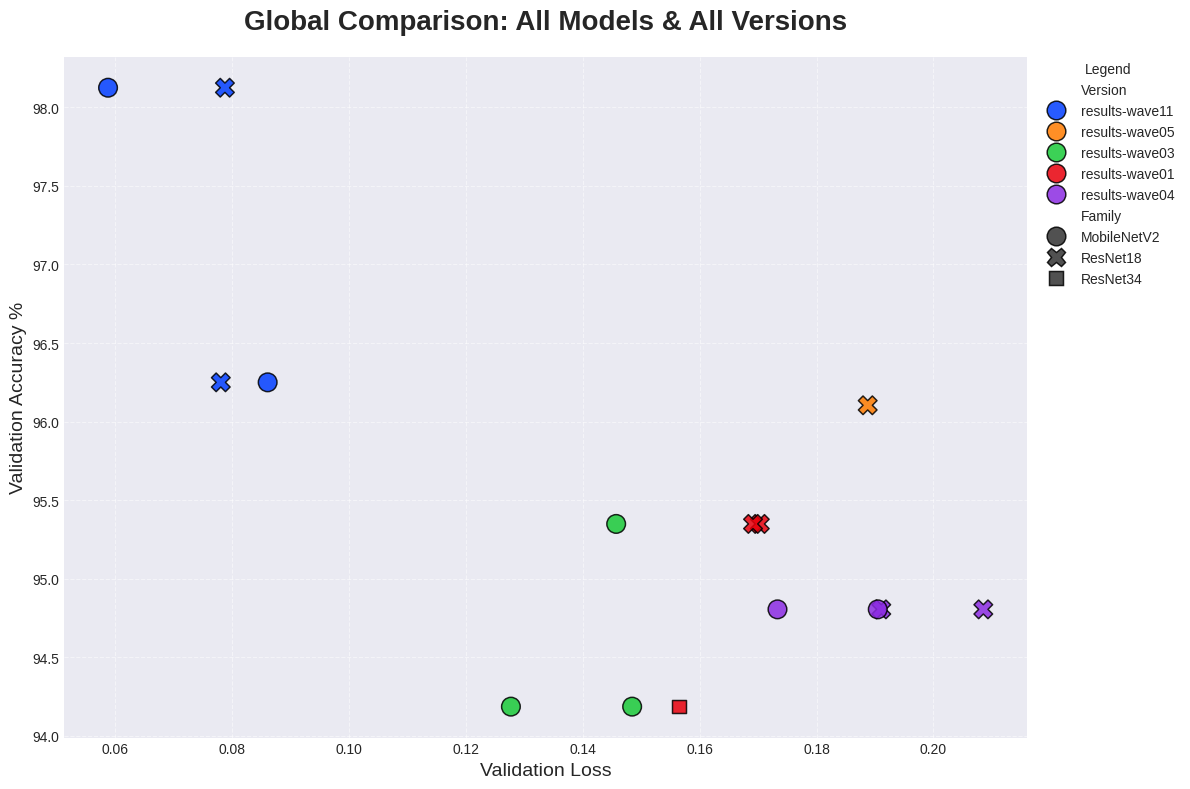

In [22]:
# Display the sorted list
print(f"\n{'='*100}")
print(f" ABSOLUTE GLOBAL RANKING (Top {TOP_N} out of {len(global_ranked)} models)")
print(f"{'='*100}\n")

display_cols = ['val_accuracy', 'val_loss', 'Version', 'Family', 'BatchSize', 'LearningRate']
print(global_ranked[display_cols].head(TOP_N))

# 3. Summary Chart
plt.figure(figsize=(12, 8))

# Usage:
# - HUE (Color) to distinguish VERSIONS (impact of training campaign)
# - STYLE (Shape) to distinguish FAMILIES (ResNet vs MobileNet...)
# - SIZE fixed for readability
sns.scatterplot(
    data=global_ranked,
    x='val_loss', 
    y='val_accuracy',
    hue='Version',      
    style='Family',     
    s=180,              
    alpha=0.85,
    palette='bright',
    edgecolor='black'
)

# Dynamic Annotation of 10 Best Models (all versions combined)
# for i, (model_name, row) in enumerate(global_ranked.head(10).iterrows()):
#     plt.annotate(
#         f"#{i+1} {model_name}", 
#         (row['val_loss'], row['val_accuracy']),
#         xytext=(0, 15 if i % 2 == 0 else -15), # Alternates top/bottom to avoid overlap
#         textcoords='offset points',
#         fontsize=9, fontweight='bold', ha='center',
#         bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.8)
#     )

plt.title("Global Comparison: All Models & All Versions", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Validation Loss", fontsize=14)
plt.ylabel("Validation Accuracy %", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend outside
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., title="Legend", fontsize='medium')

plt.tight_layout()
plt.show()


 DETAILED HYPERPARAMETER ANALYSIS ON GLOBAL TOP 15



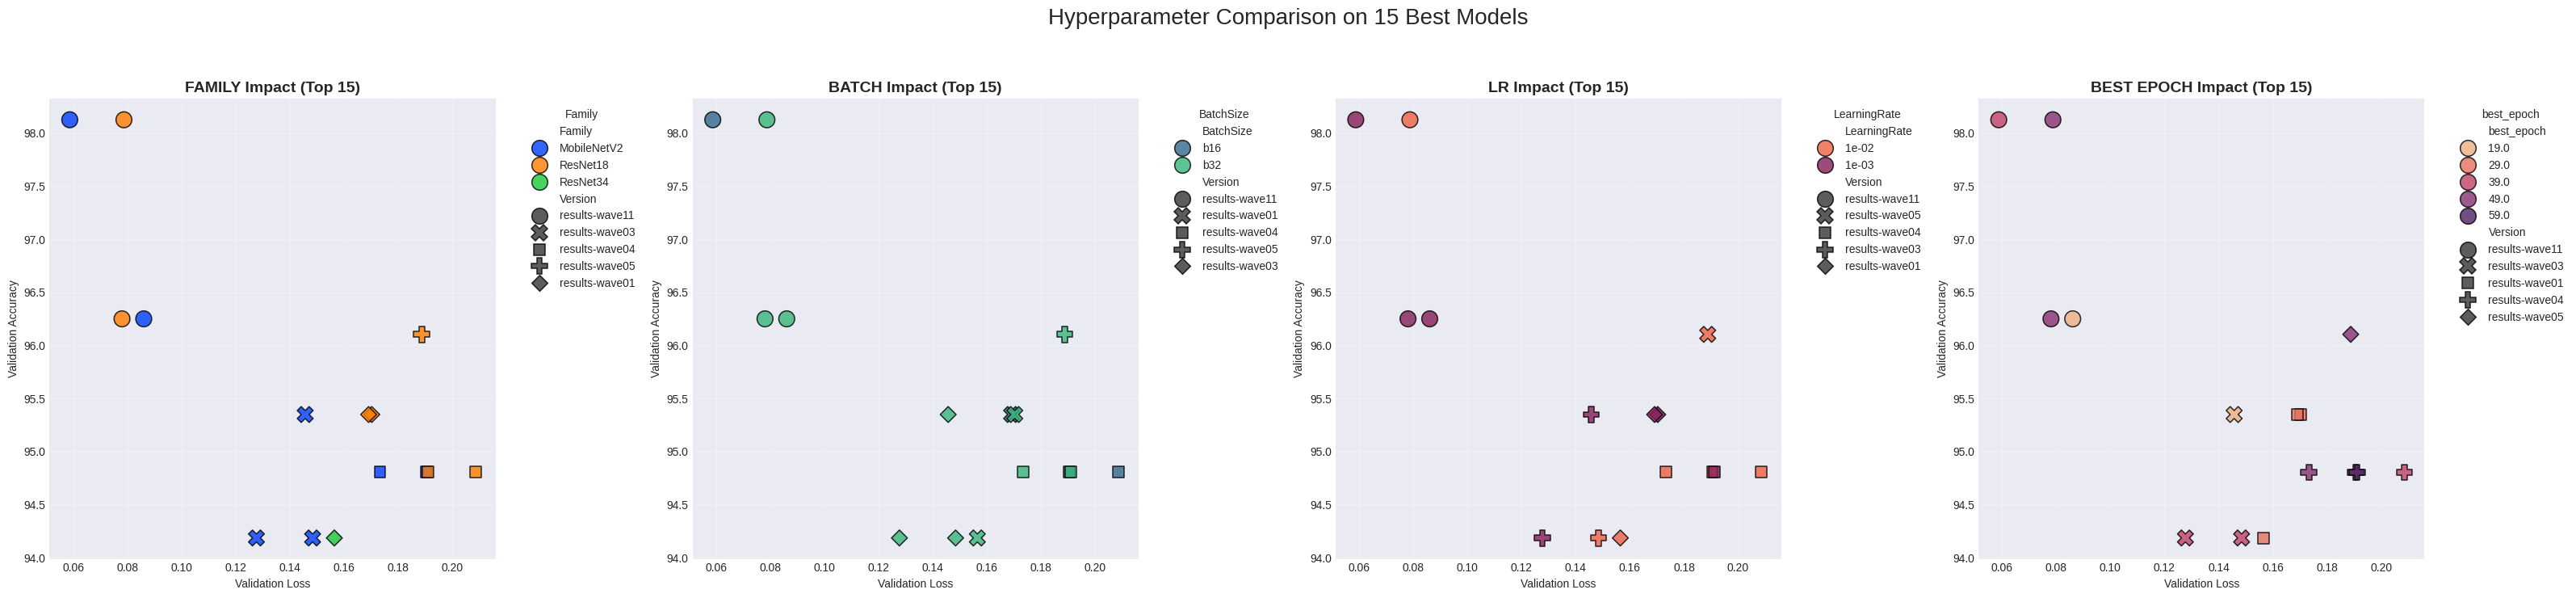

In [23]:
# --- DETAILED HYPERPARAMETER DISPLAY (GLOBAL TOP 15) ---

print(f"\n{'='*100}")
print(f" DETAILED HYPERPARAMETER ANALYSIS ON GLOBAL TOP {TOP_N}")
print(f"{'='*100}\n")

# Working on the subset of 15 best models
top_models_df = global_ranked.head(TOP_N).copy()

fig, axes = plt.subplots(1, 4, figsize=(32, 7)) # 1 row, 4 columns

plot_configs = [
    {'col': 'Family',       'title': 'FAMILY Impact',    'palette': 'bright'},
    {'col': 'BatchSize',    'title': 'BATCH Impact',      'palette': 'viridis'},
    {'col': 'LearningRate', 'title': 'LR Impact',         'palette': 'rocket_r'},
    {'col': 'best_epoch',   'title': 'BEST EPOCH Impact', 'palette': 'flare'}
]

for i, config in enumerate(plot_configs):
    col_name = config['col']
    
    # Local sort for legend
    current_data = top_models_df.sort_values(col_name)
    style_param = 'Version' # Use version as style to distinguish waves
    
    # Scatterplot
    sns.scatterplot(
        data=current_data, 
        x='val_loss', 
        y='val_accuracy', 
        hue=col_name,           # Color by hyperparameter
        style=style_param,      # Shape by version
        s=200, 
        alpha=0.8, 
        palette=config['palette'], 
        ax=axes[i],
        edgecolor='black'
    )
    
    axes[i].set_title(f"{config['title']} (Top {TOP_N})", fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Validation Loss')
    axes[i].set_ylabel('Validation Accuracy')
    axes[i].grid(True, alpha=0.3)
    
    # Improved legend
    if axes[i].legend_: 
        axes[i].legend(title=col_name, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle(f"Hyperparameter Comparison on {TOP_N} Best Models", fontsize=20, y=1.05)
plt.tight_layout()
plt.show()


 LEARNING CURVES: GLOBAL TOP 15 BEST MODELS



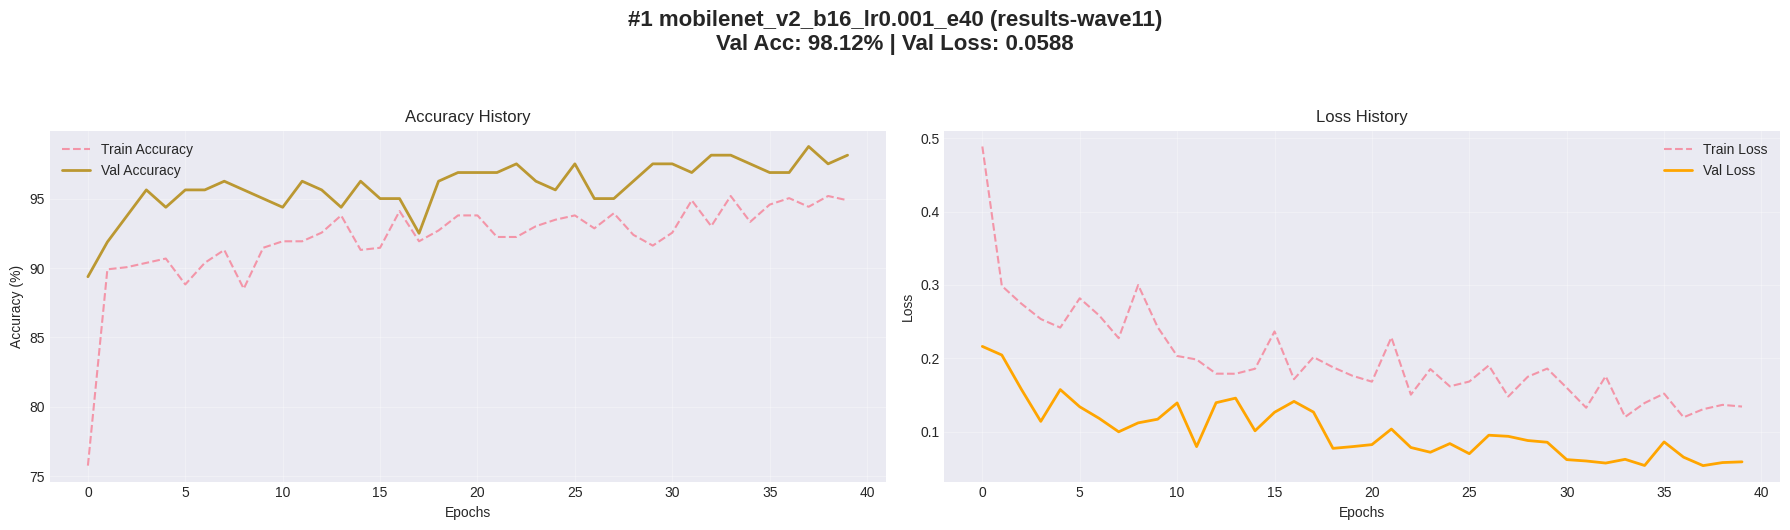

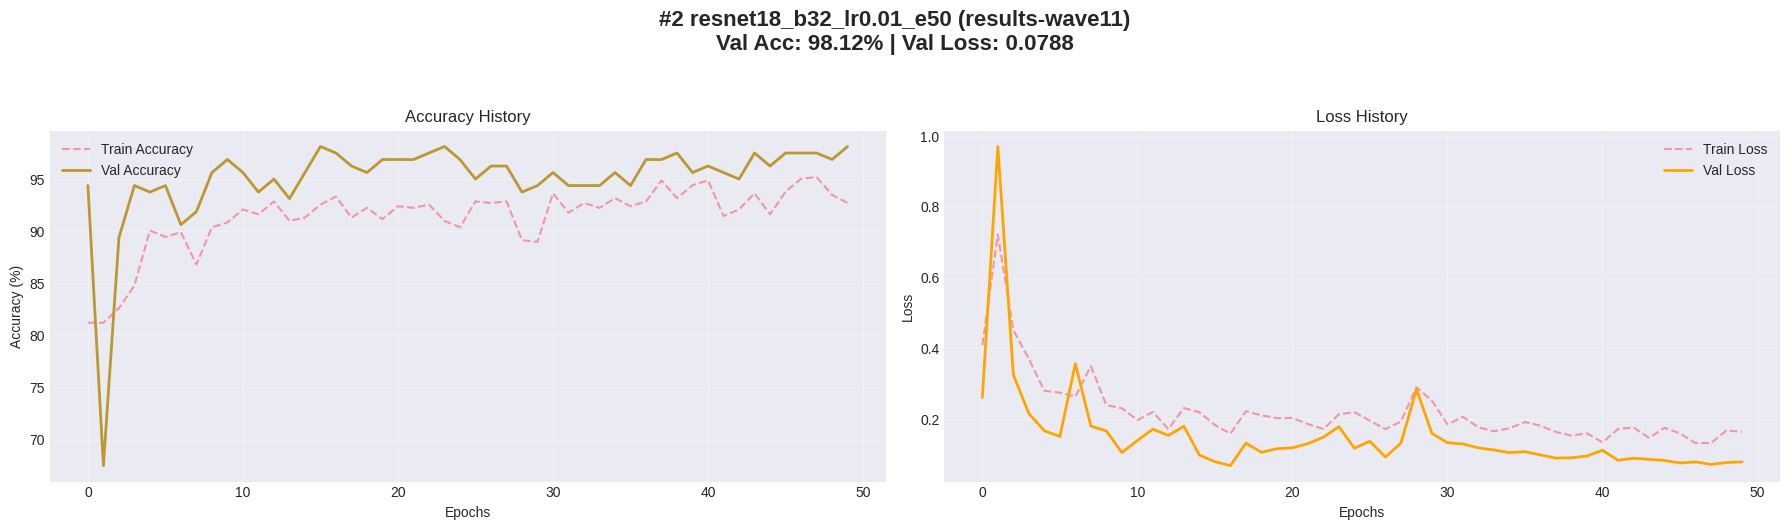

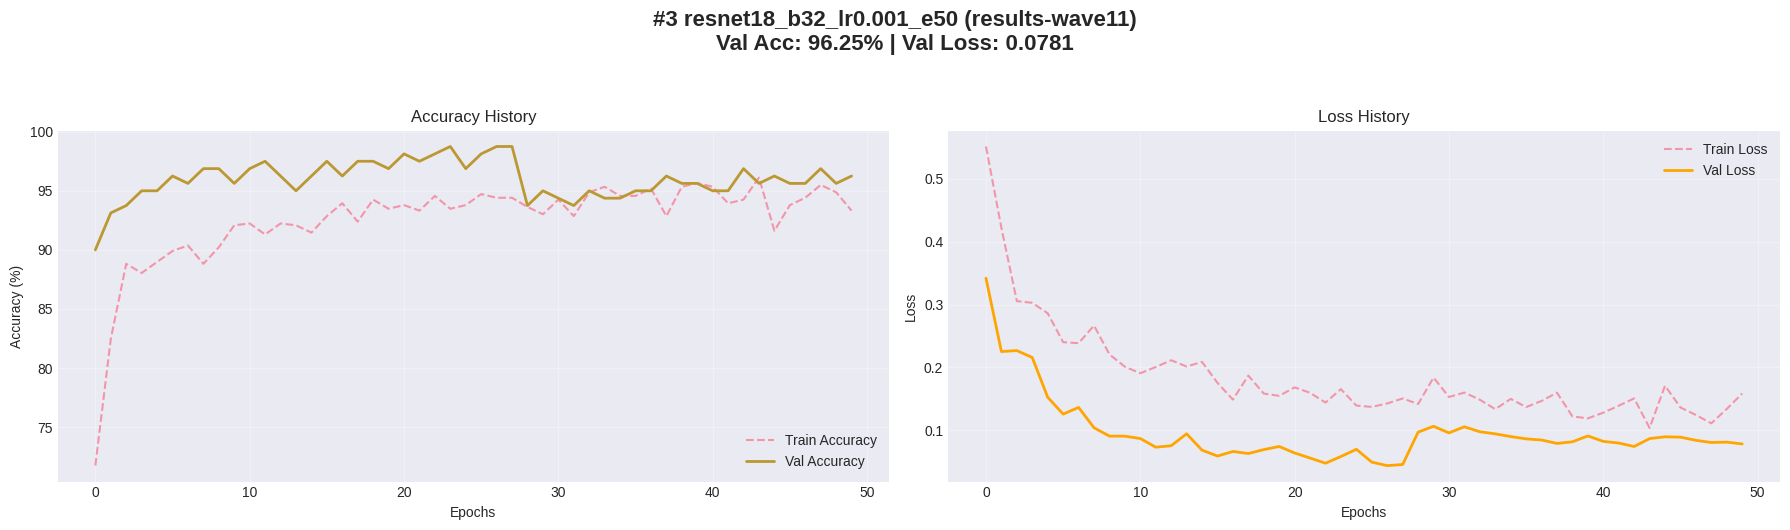

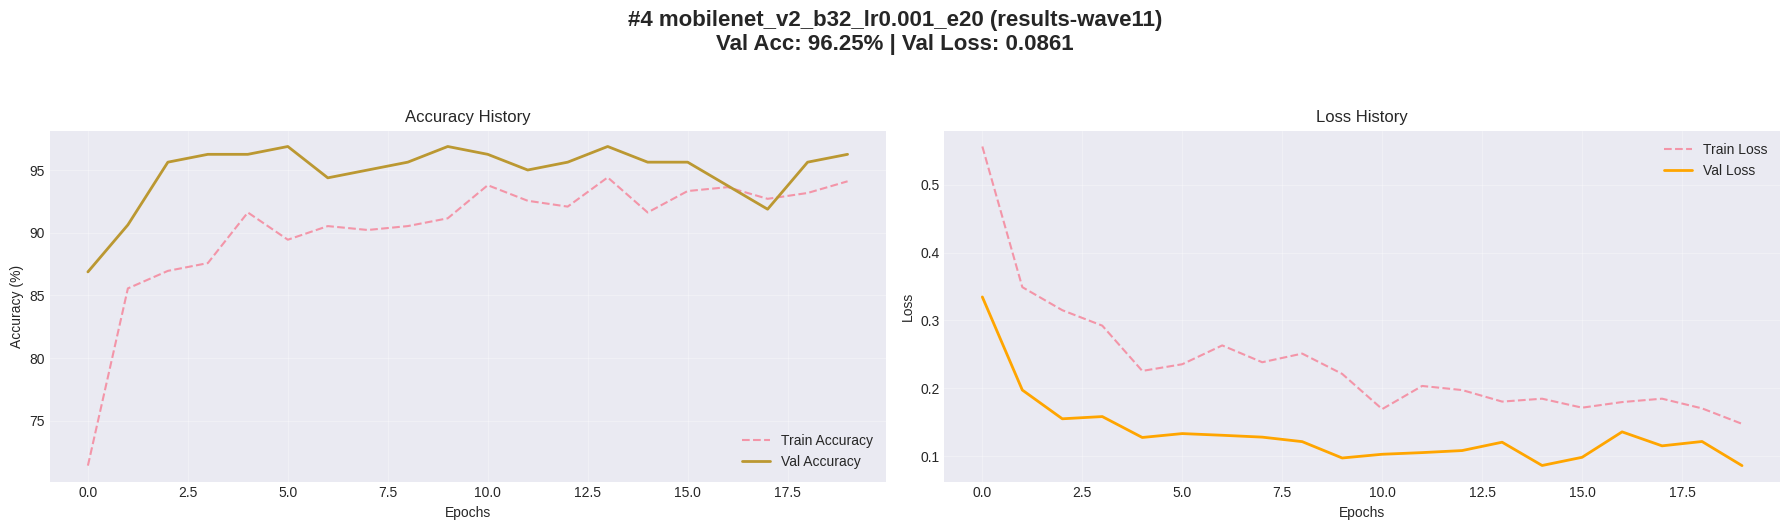

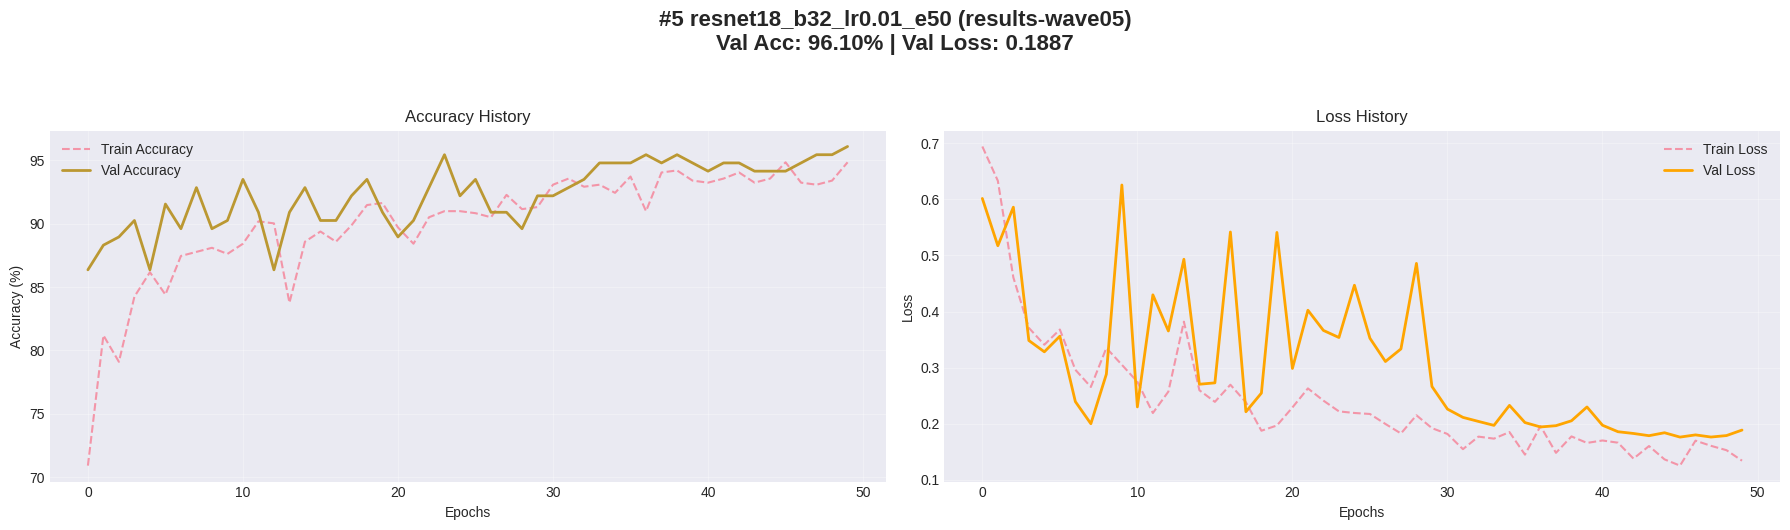

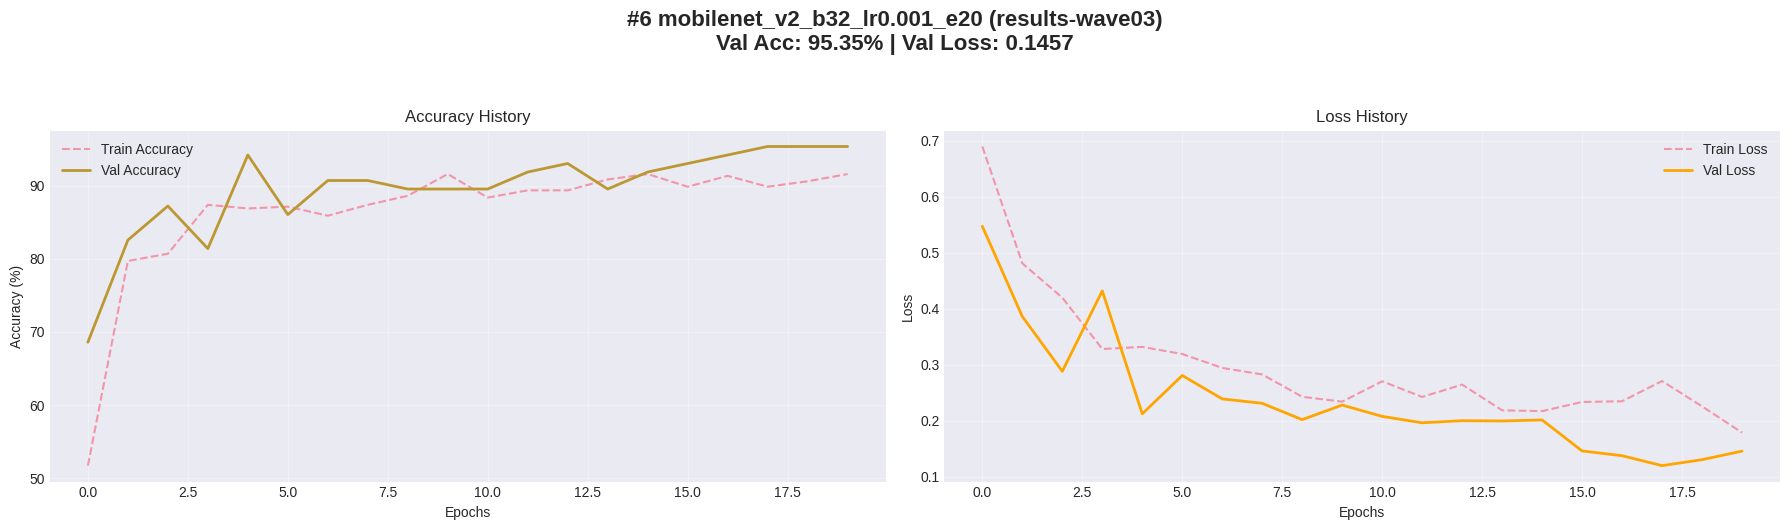

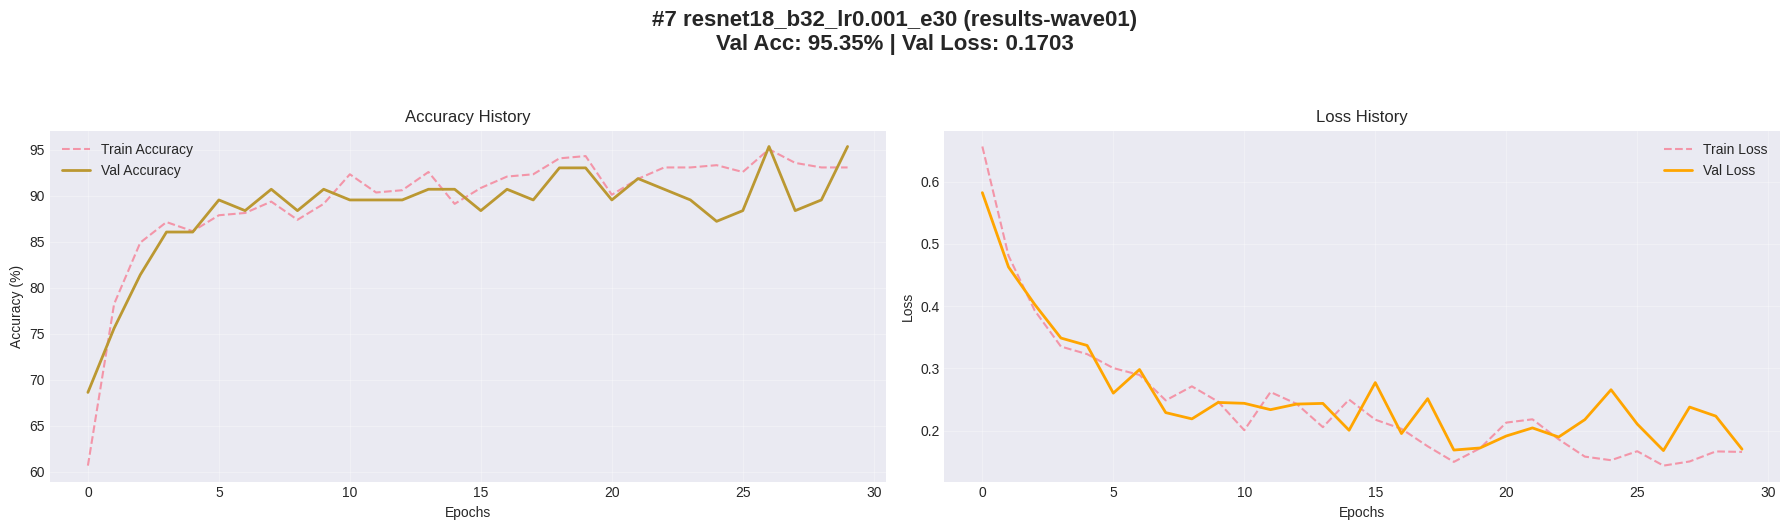

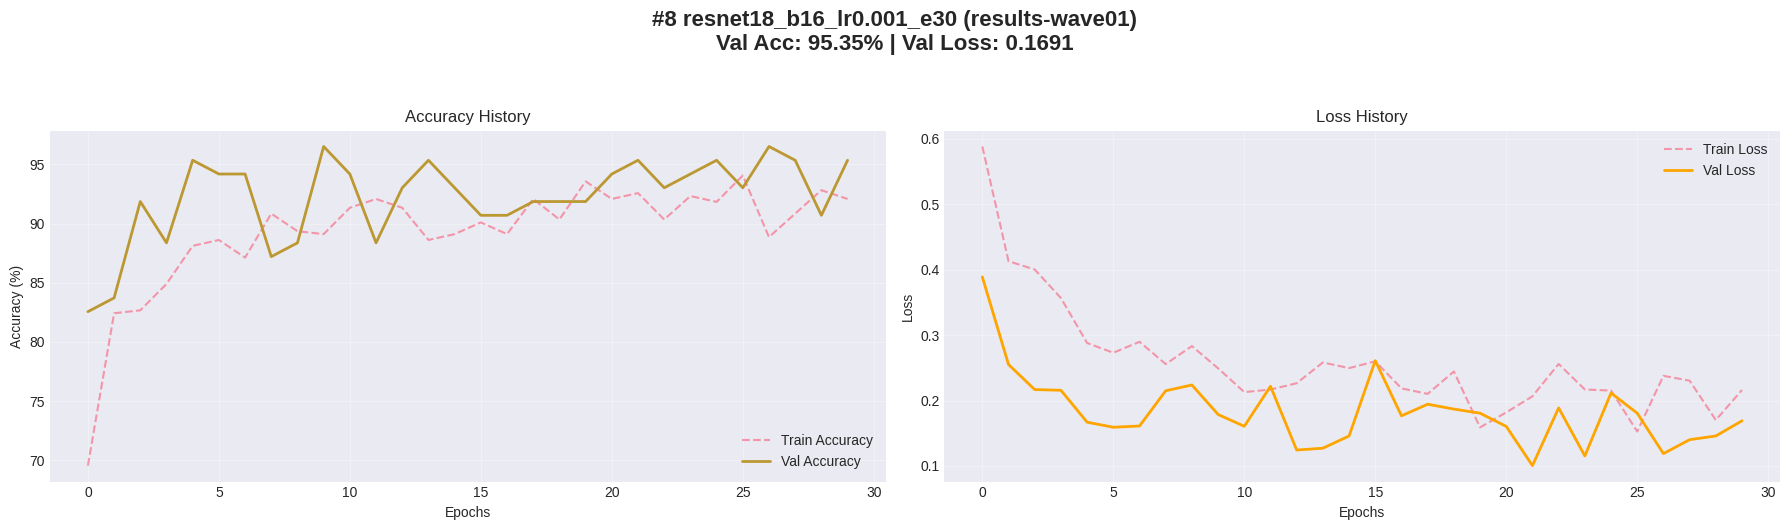

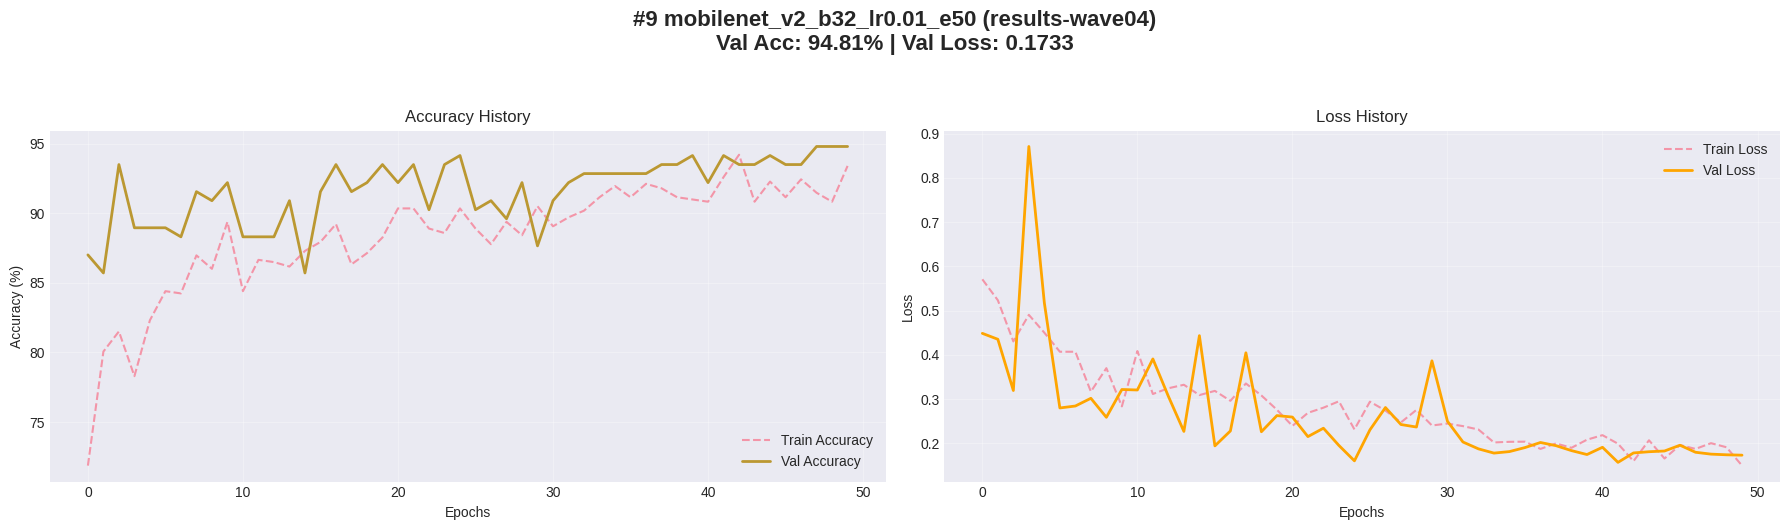

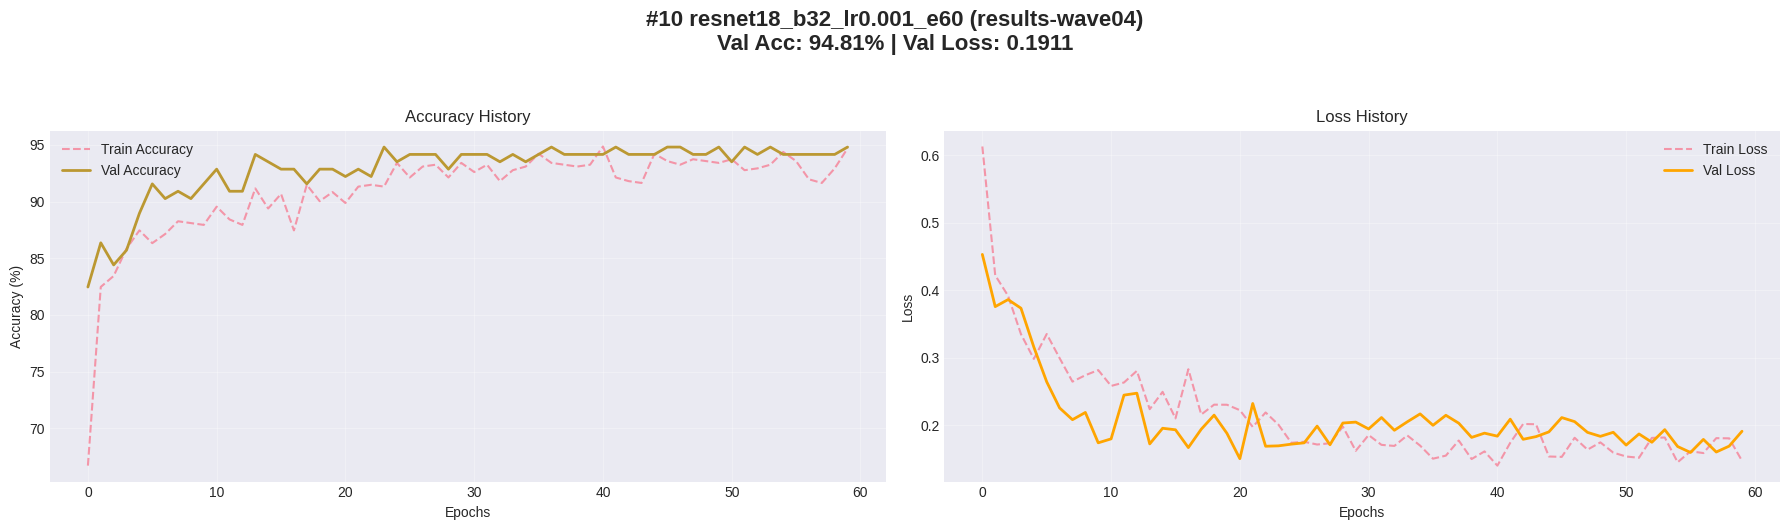

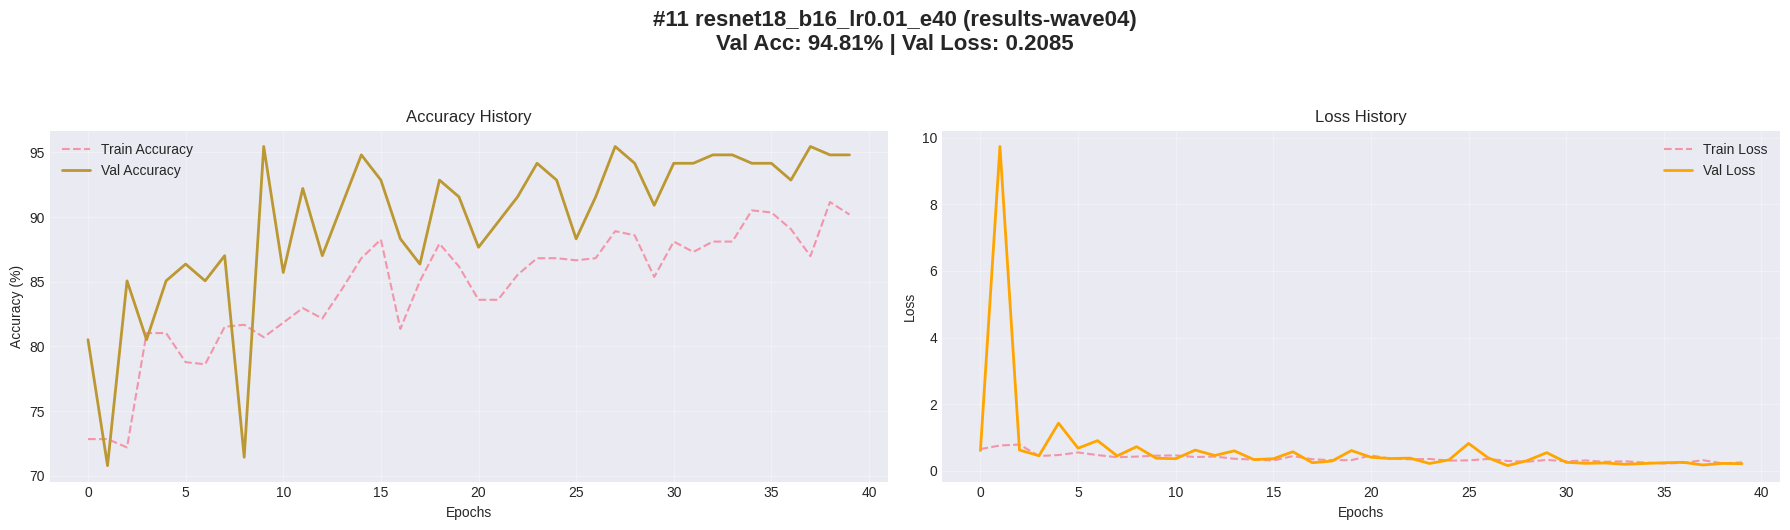

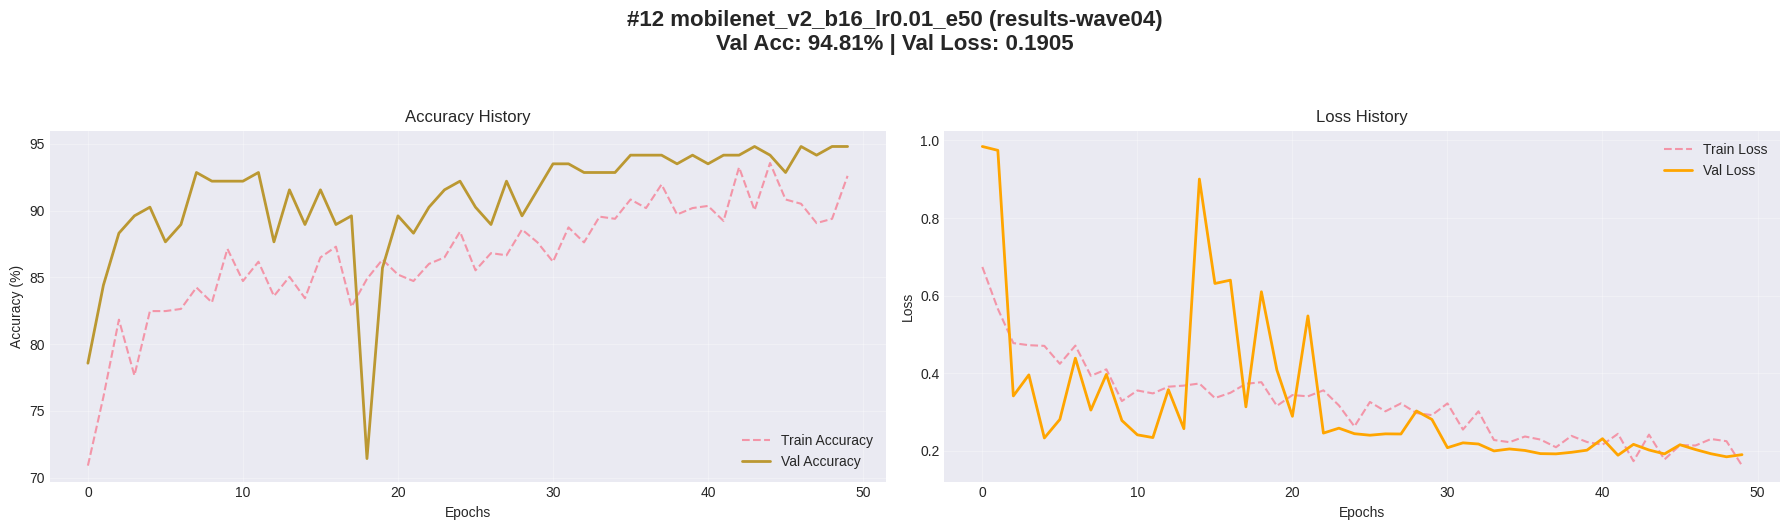

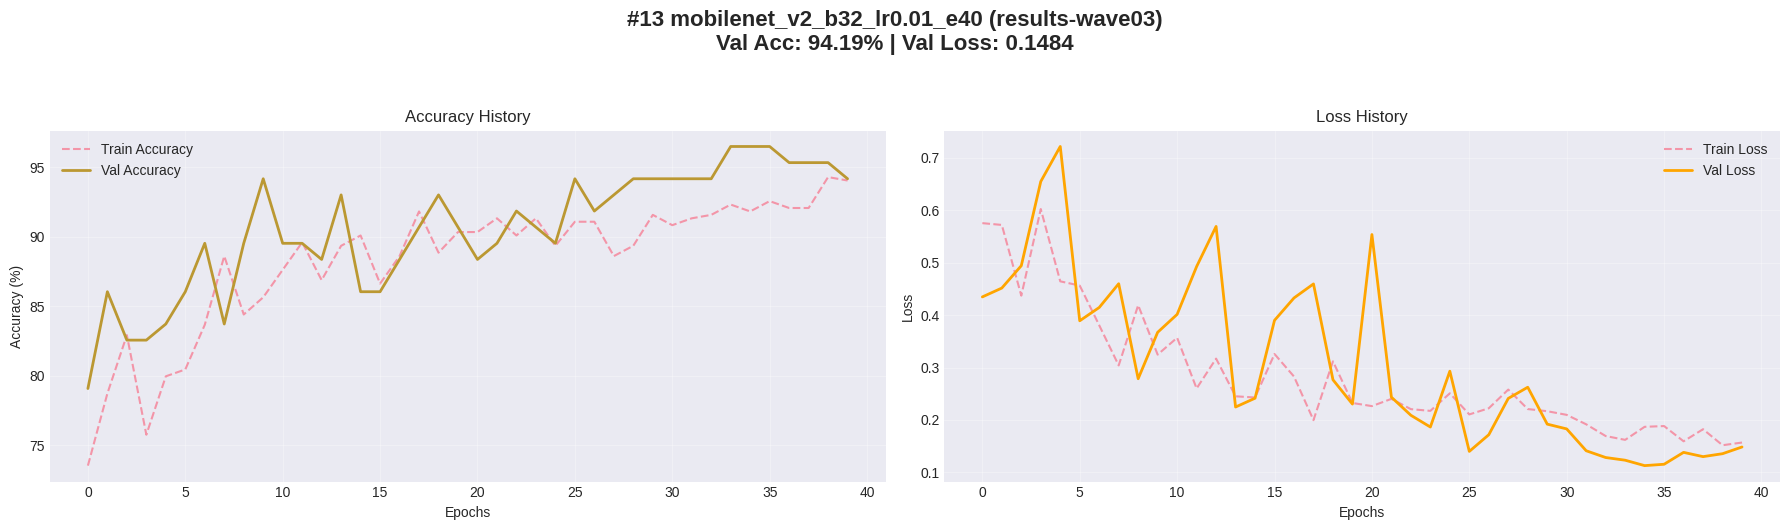

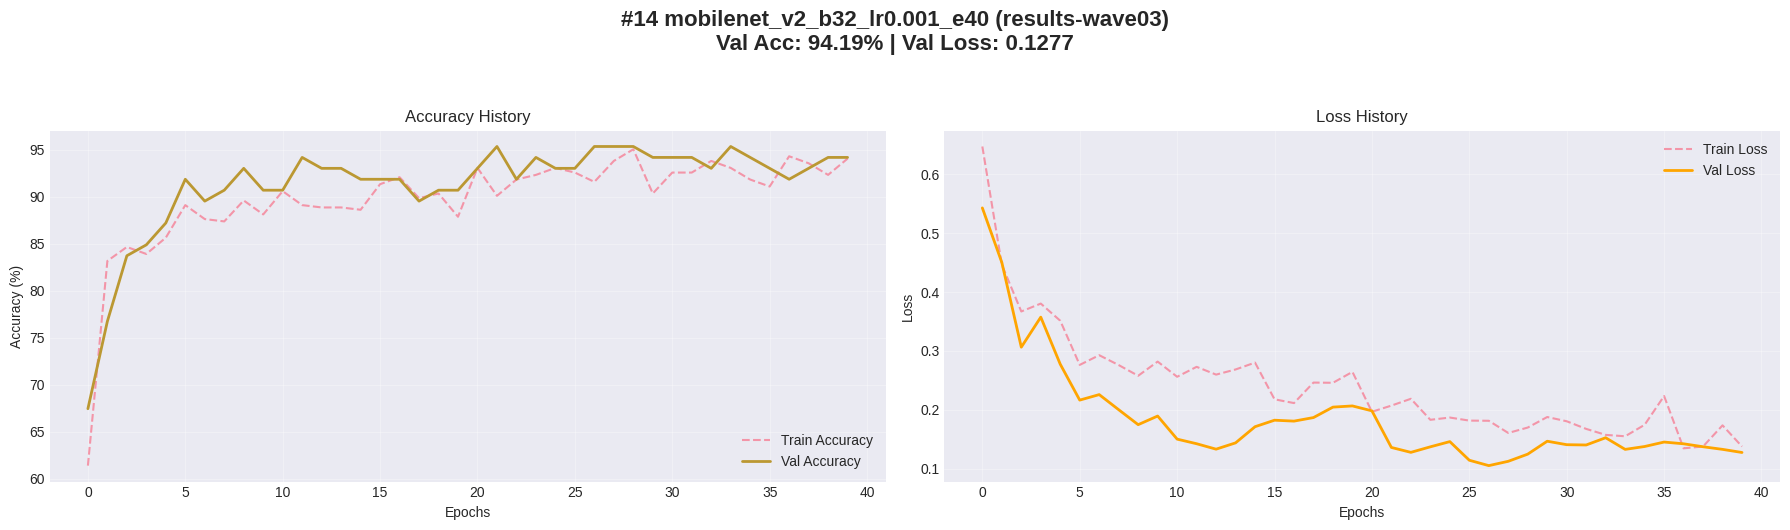

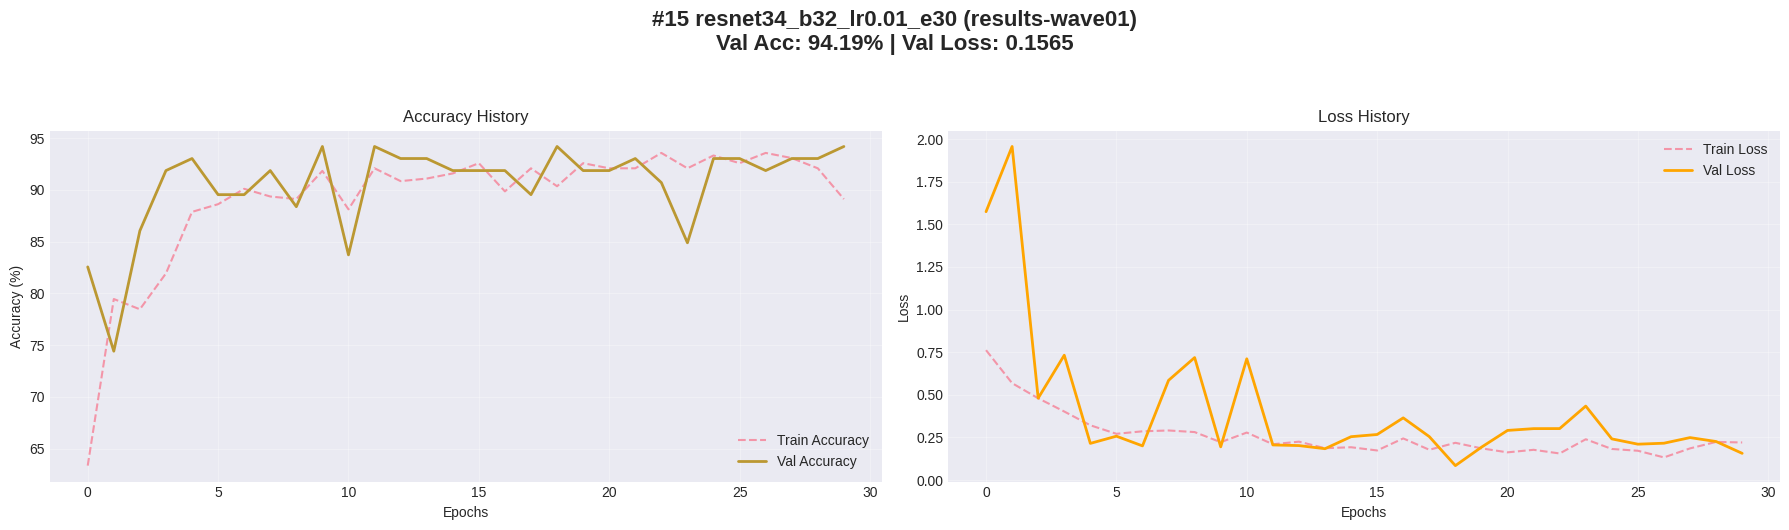

In [24]:
# --- LEARNING CURVES DISPLAY FOR TOP MODELS ---

print(f"\n{'='*100}")
print(f" LEARNING CURVES: GLOBAL TOP {TOP_N} BEST MODELS")
print(f"{'='*100}\n")

# Iterate over N best from global ranking
for i, (model_name, row) in enumerate(global_ranked.head(TOP_N).iterrows()):
    version = row['Version']
    
    # Path reconstruction
    model_path = Path(base_folder) / version / model_name / metrics_folder
    
    # History loading
    try:
        t_acc = pd.read_csv(model_path / "train_accuracy.csv", header=None)[0]
        v_acc = pd.read_csv(model_path / "val_accuracy.csv", header=None)[0]
        t_loss = pd.read_csv(model_path / "train_loss.csv", header=None)[0]
        v_loss = pd.read_csv(model_path / "val_loss.csv", header=None)[0]
        
        # Figure creation (2 side-by-side charts: Accuracy and Loss)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
        
        # Global Title with performance
        fig.suptitle(f"#{i+1} {model_name} ({version})\n"
                     f"Val Acc: {row['val_accuracy']:.2f}% | Val Loss: {row['val_loss']:.4f}", 
                     fontsize=16, fontweight='bold', y=1.05)
        
        # Accuracy Chart
        ax1.plot(t_acc, label='Train Accuracy', linestyle='--', alpha=0.7)
        ax1.plot(v_acc, label='Val Accuracy', linewidth=2)
        ax1.set_title('Accuracy History')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy (%)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Loss Chart
        ax2.plot(t_loss, label='Train Loss', linestyle='--', alpha=0.7)
        ax2.plot(v_loss, label='Val Loss', linewidth=2, color='orange')
        ax2.set_title('Loss History')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except FileNotFoundError as e:
        print(f"⚠️ Unable to load history for {model_name} : {e}")